In [1]:
:ext TypeSynonymInstances
:ext FlexibleInstances

In [2]:
import Data.Text (pack)
import Data.Tuple.Extra (first, second, (***), (&&&))
import Data.List.Extra (dropEnd, enumerate, nub)
-- import Control.Monad.Trans.State
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Utils
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate
-- import qualified System.Random.MWC.Probability as MWC

In [4]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

# Setting Things Up

## The Model

**Worlds** are distinguished only by the height of Joan

In [5]:
data World = World {label :: String, ht :: Int, foil :: Int} deriving Eq

In [6]:
instance Ord World where
  w <= w' = ht w <= ht w'

instance Show World where
  show (World l _ _) = l

We assume speakers reason simultaneously about Joan's height and the distribution of the comparison class, so **indices** pair a world together with a comparison class. The possible comparison classes are assumed to be normally distributed, all with the same standard deviation, so we represent them here simply by their mean.

In [7]:
type Index = (World, Int)

In [8]:
instance {-# OVERLAPPING #-} Show Index where
  show (w,i) = show w ++ ";" ++ show i
 
eccentricity :: Index -> Int
eccentricity (w,i) = ht w - i

A **proposition** is a set of these (literally) centered worlds

In [9]:
type Prop = [Index]

For the sake of computational efficiency, we imagine that there are only 11 possible heights that Joan might take

In [10]:
heights = [1 .. 17]
universe = [World ("j" ++ show h) h 1 | h <- heights]

Again for efficiency's sake, not all world-center pairs are considered possible. The median height is assumed to fall between $4$ and $8$, and Joan's height is assumed to fall within $3$ steps of the median: 

\begin{equation} C_{\textsf{j}} \subseteq \Bigl\{\langle w, \mu\rangle \Bigm\vert 4 \leq \mu \leq 8,\ -3 \leq \mu - \textsf{ht}_{w}(\textsf{j}) \leq 3\Bigr\} \end{equation}

In [11]:
midpoint = (ceiling $ maximum heights / 2) :: Int
sigma = 4 :: Int
htrange = [-sigma .. sigma]
indices = [(w, mu) | mu <- drop sigma . dropEnd sigma $ heights, w <- universe, abs (ht w - mu) <= sigma]

## The Language

We have a marked utterance, an unmarked utterance, and a null utterance (the least marked)

In [12]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Ord, Enum, Bounded)
  
instance Show Utt where
  show UNone = "silence"
  show UTall = "... tall ..."
  show UShrt = "... short ..."

utterances = enumerate

A **lexicon** is a denotation function mapping utterances to propositions

In [13]:
data Lexicon = Lex {lexID :: Int, den :: Utt -> Prop}

In [14]:
instance Show Lexicon where
  show (Lex _ f) = "C = " ++ show (f UNone) ++ "; E = " ++ show (f UTall)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [15]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Lexicon) (Dist Index))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [16]:
data Priors = Priors {ip :: Model Index, up :: Model Utt, lp :: Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Lexicon) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (itself determined by the markedness of the utterance) and the likelihood that a listener would choose $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would choose $u$ upon trying to describe $i$

In [17]:
alpha :: Double
alpha = 4

speaker :: Agent Index Utt
speaker priors ref (n,i,l) =
  do u <- up priors
     if null (den l u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,l)
               weight $ alpha * logProb lnr i
     return u

listener :: Agent Utt (Index, Lexicon)
listener priors ref (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speaker priors ref (n,index,interp)
         observe spr u
         return (index, interp)
  | otherwise =
      do index  <- ip priors
         condition (index `elem` den l u)
         return (index, l)

# Experiments

Prior belief about indices is that people are normally sized. That is, the median height is unknown, but whatever it is, the world where Joan has that height is more likely than the worlds where Joan is above it or below it, and then worlds where Joan is very far from the median are less likely than wolrds where she is close to it.

In [18]:
indicesPriorFlat :: Model Index
indicesPriorFlat =
  do (w,i) <- unif indices
     observe (Normal 0 2.00) (fromIntegral $ ht w - i)
     return (w,i)

Here is a map showing this naive agent's prior about possible states of affairs. Possible comparison class means are arranged along the $x$ axis, and possible values for Joan's height along the $y$ axis. Cells are annotated with their probabilities (darker is more likely). The marginal distributions over Joan's height and the possible comparison classes are projected at the margins.

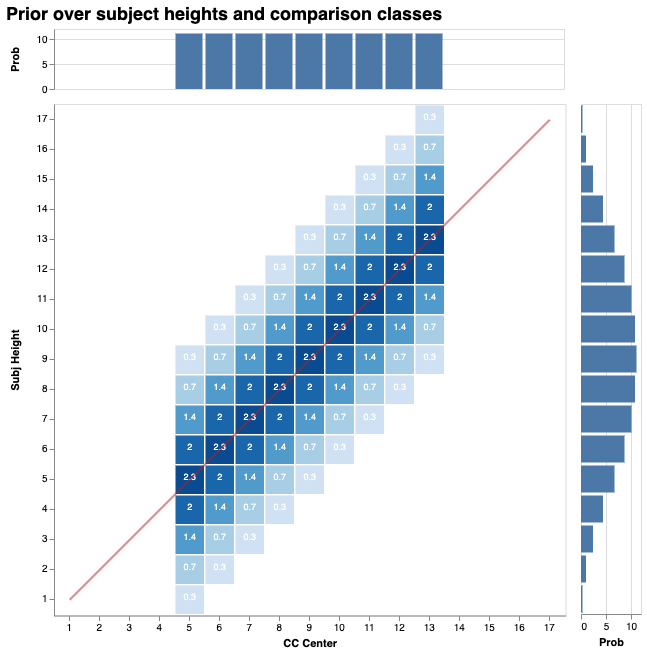

In [19]:
let addTitle s v = toVegaLite [title (pack s) [TFontSize 18], vConcat [fromVL v]]
vlShow
  . addTitle "Prior over subject heights and comparison classes"
  . margHeatFromDist
  <$> enumD (first ht <$> indicesPriorFlat)

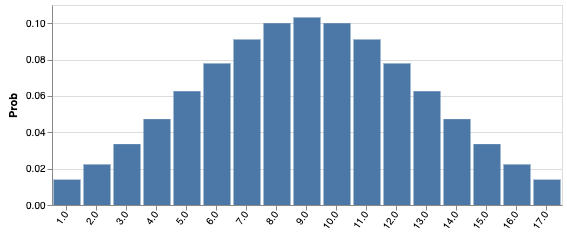

In [20]:
vlShow . barFromDist <$>  enumD (unif heights >>= \h -> observe (Normal 9 4.0) h >> return h)

Exogenous costs influence the prior likelihoods of utterances. We do not attempt to explain why one utterance is more marked than another. We assume only that there are differences. The actual values here are not particularly important.

In [21]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

In [22]:
utterancePrior1 :: Model Utt
utterancePrior1 = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

Given these costs, a speaker will strongly prefer to say nothing, and then if forced to speak, will strongly prefer to use the unmarked utterance to the marked one

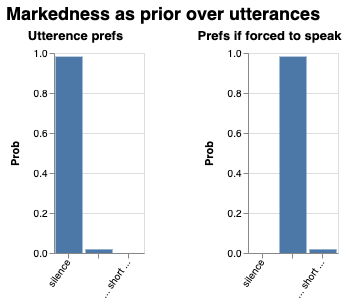

In [23]:
vlShow . addTitle "Markedness as prior over utterances" . sidewaysDists <$> sequence
  [ titled "Utterence prefs" . barFromDist <$> enumD utterancePrior1
  , titled "Prefs if forced to speak" . barFromDist <$>
      enumD (utterancePrior1 >>= \u -> condition (u /= UNone) >> return u)
  ]

## Positive Utterances

With these priors, we now model pragmatic listeners who consider various strengthenings of the assertion. Note that these are strengthenings in the dynamic sense of ruling out more "contexts" (here, comparison classes); the pure informational content about Joan's height is the same in all lexica.

Baseline `den0` lexicon interprets both antonyms as contextual tautologies (Joan's height is within 3 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') places Joan in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
[\![\text{Joan is tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) \geq \mu + \sigma\\
[\![\text{Joan is short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) \leq \mu + \sigma
\end{align}

In [24]:
den0 :: Lexicon
den0 = Lex 0 f
  where f _ = indices

posDens :: [Lexicon]
posDens =
  do d <- htrange
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w <= i + d) indices
     return (Lex d f)

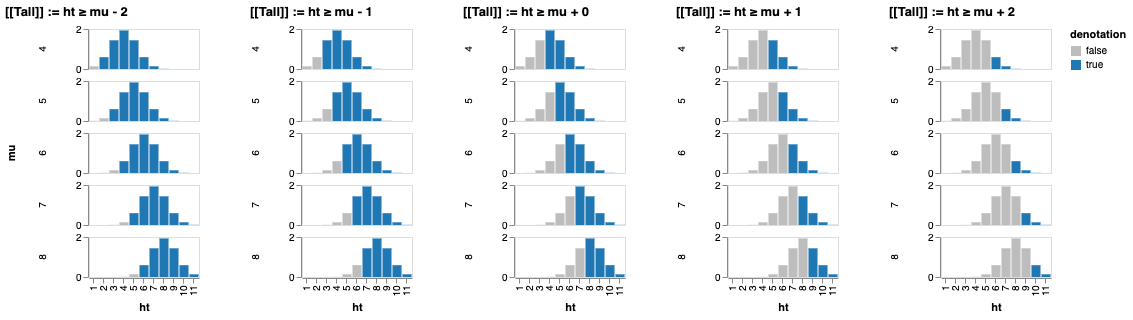

In [25]:
import IHaskell.Display (Display(..), javascript, vegalite)
import System.IO
readFile "posDens.vl" >>= \js -> pure (Display [vegalite js])

In [26]:
infoBaseline = Priors indicesPriorFlat utterancePrior1 (unif [den0])
infoLUM = infoBaseline {lp = unif posDens}

### Pragmatic agents

#### Pragmatic listener hears:

> "Joan is tall"

As pragmatic iterations proceed, listeners become very confident that Joan's height exceeds the median, though they remain in the dark about what the median is

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that Joan's height exceeds it leads to a (positively skewed) evaluative distribution over worlds

The red graph under each heatmap provides the listener's posterior estimate about which lexicon the speaker intended. This ceases to make sense after L1, where this choice is marginalized over

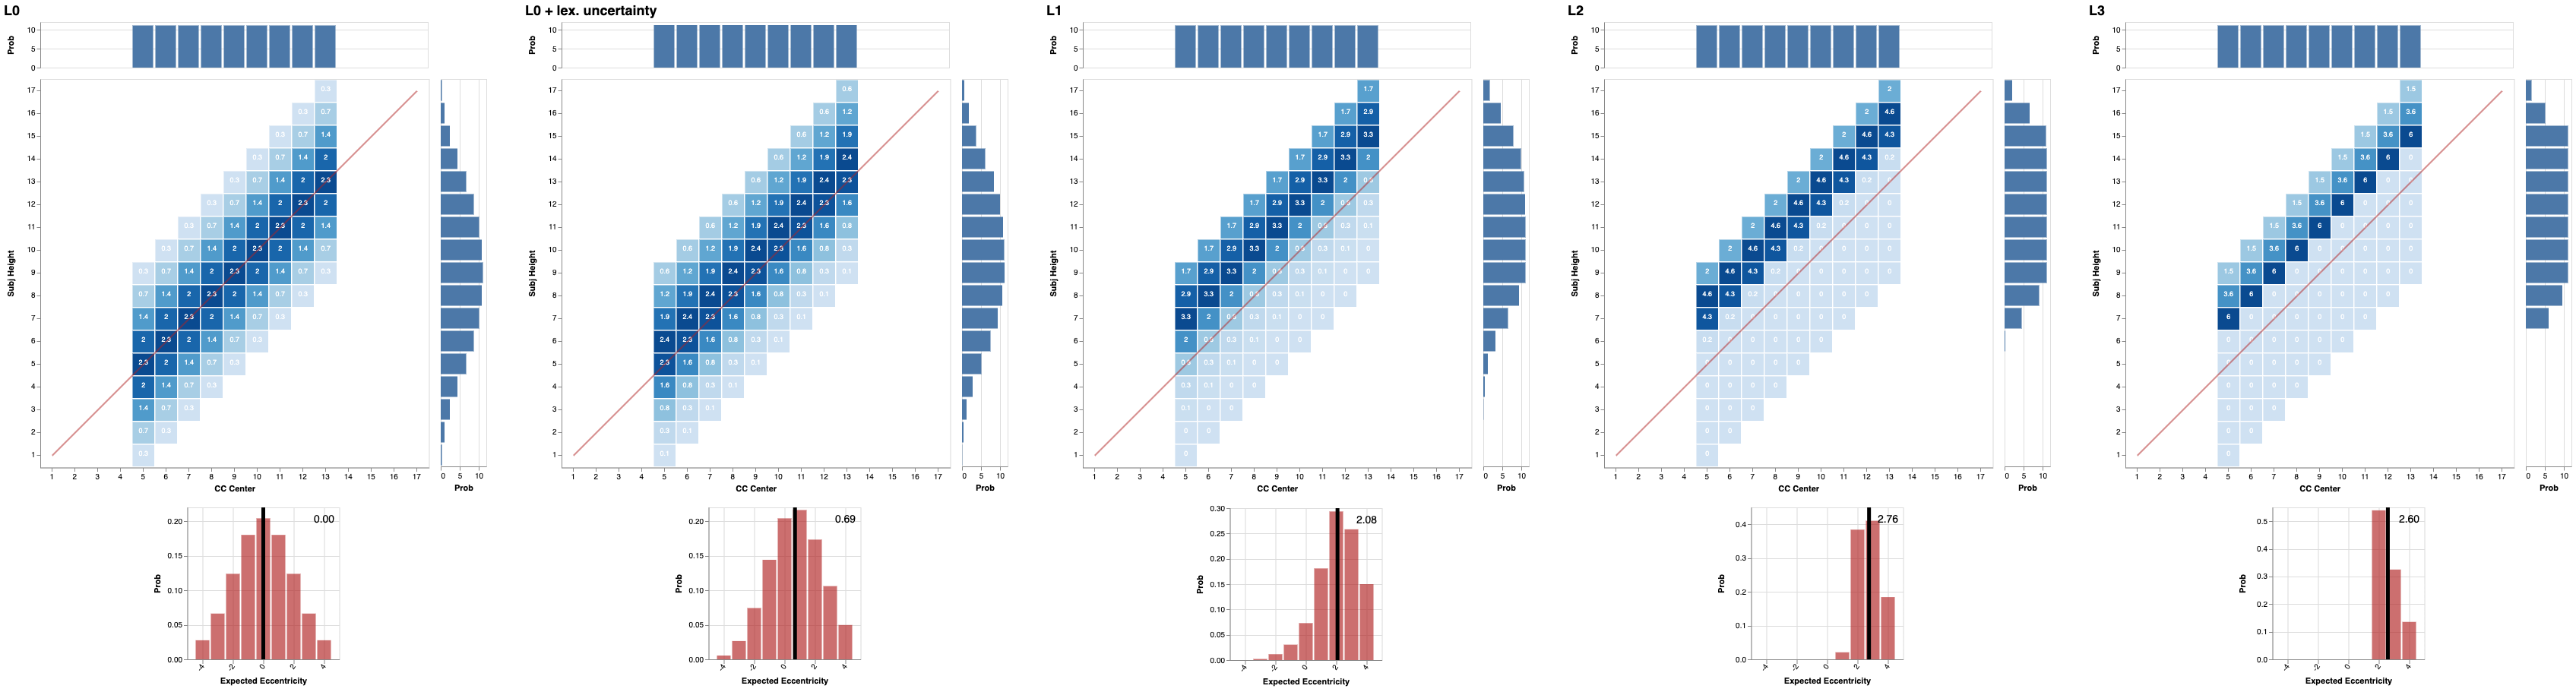

In [27]:
writeIORef cacheRef (0, Map.empty)

mkGraph (t, m) = do
  heat <- enumD (first ht    . fst <$> m)
--   bar  <- enumD (lexID    . snd <$> m)
  bar <- enumD (eccentricity . fst <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [ fromVL (margHeatFromDist heat)
              , fromVL (sdBarFromDist htrange bar)
              ]
    , title (pack t) [TFontSize 18]
    ]
    
-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUM cacheRef (0, UTall, den0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UTall, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUM cacheRef (1, UTall, den0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUM cacheRef (2, UTall, den0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUM cacheRef (3, UTall, den0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUM cacheRef (0, UTall, den0))
  , ("L0 + lex. uncertainty", lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UTall, l))
  , ("L1", listener infoLUM cacheRef (1, UTall, den0))
  , ("L2", listener infoLUM cacheRef (2, UTall, den0))
  , ("L3", listener infoLUM cacheRef (3, UTall, den0))
  ]

#### Pragmatic listener hears:

> "Joan is short"

As pragmatic iterations proceed, listeners become absolutely certain that Joan's height falls below the standard, though they remain in the dark about what the standard is

And as seen in the `ht` marginal, even though the median remains unknown, the belief that Joan's height falls below it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect here is very strong

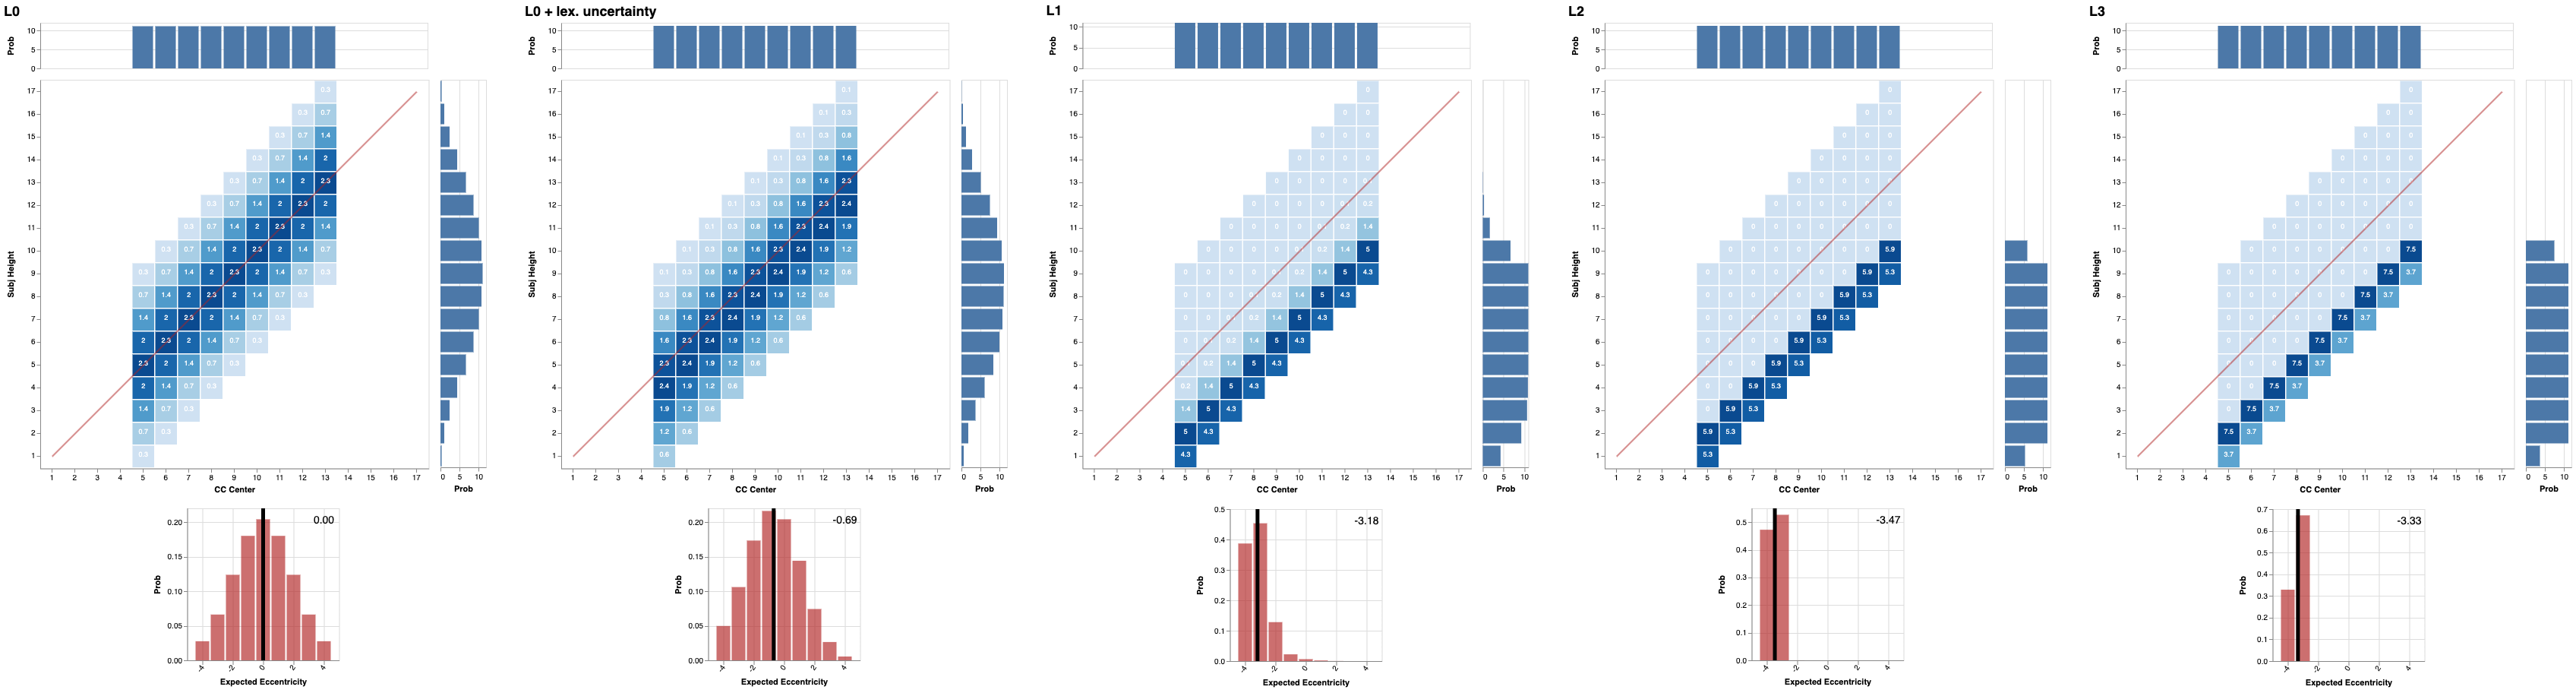

In [28]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUM cacheRef (0, UShrt, den0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UShrt, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUM cacheRef (1, UShrt, den0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUM cacheRef (2, UShrt, den0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUM cacheRef (3, UShrt, den0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUM cacheRef (0, UShrt, den0))
  , ("L0 + lex. uncertainty", lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UShrt, l))
  , ("L1", listener infoLUM cacheRef (1, UShrt, den0))
  , ("L2", listener infoLUM cacheRef (2, UShrt, den0))
  , ("L3", listener infoLUM cacheRef (3, UShrt, den0))
  ]

## Degree demonstrative

All adjectival utterances are now interpreted as entailing that Joan's height is 6

In the baseline lexicon `denExact0`, this is all that is contributed by an utterance

Other interpretations place Joan's height at 6 and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is 6-tall}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = 6 \land 6 \geq \mu + \sigma\end{equation}

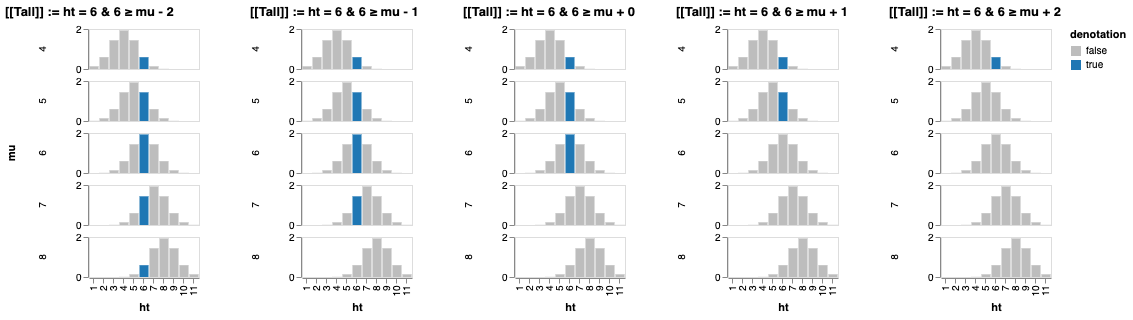

In [29]:
readFile "exactDens.vl" >>= \js -> pure (Display [vegalite js])

In [30]:
denExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w == midpoint) indices
        f UShrt = filter (\(w,i) -> ht w == midpoint) indices

exactDens :: [Lexicon]
exactDens = 
  do d <- htrange
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w == midpoint && midpoint >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w == midpoint && midpoint <= i + d) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; Joan is that tall too"

Consider a listener that is not settled on one of these stengthenings

In [31]:
infoLUMExact = infoBaseline {lp = unif exactDens}

Of course since all of the lexica entail that Joan's height is 6, the distribution over worlds is completely determinate

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone like Joan (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

So to the extent that this is an evaluative conclusion, it is very weak

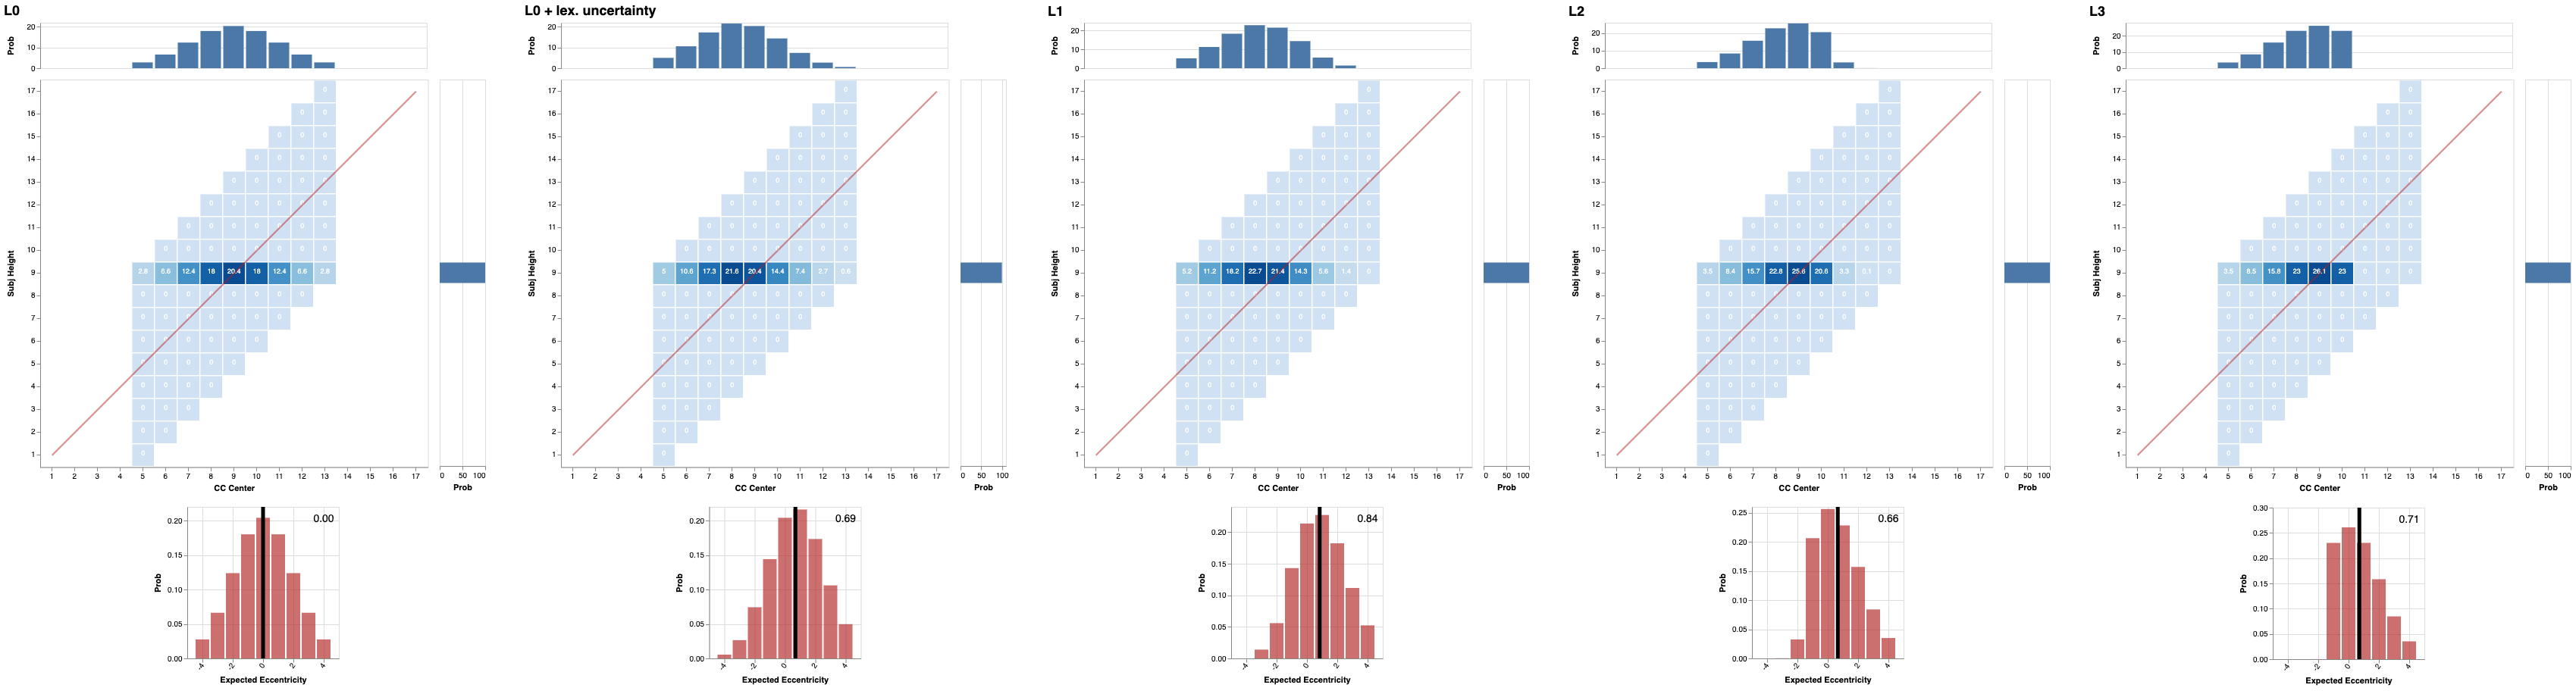

In [32]:
writeIORef cacheRef (0, Map.empty)
 
-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUMExact cacheRef (0, UTall, denExact0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUMExact >>= \l -> listener infoLUMExact cacheRef (0, UTall, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUMExact cacheRef (1, UTall, denExact0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUMExact cacheRef (2, UTall, denExact0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUMExact cacheRef (3, UTall, denExact0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUMExact cacheRef (0, UTall, denExact0))
  , ("L0 + lex. uncertainty", lp infoLUMExact>>= \l -> listener infoLUMExact cacheRef (0, UTall, l))
  , ("L1", listener infoLUMExact cacheRef (1, UTall, denExact0))
  , ("L2", listener infoLUMExact cacheRef (2, UTall, denExact0))
  , ("L3", listener infoLUMExact cacheRef (3, UTall, denExact0))
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; Joan is that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

So again the evaluativity effect is much stronger

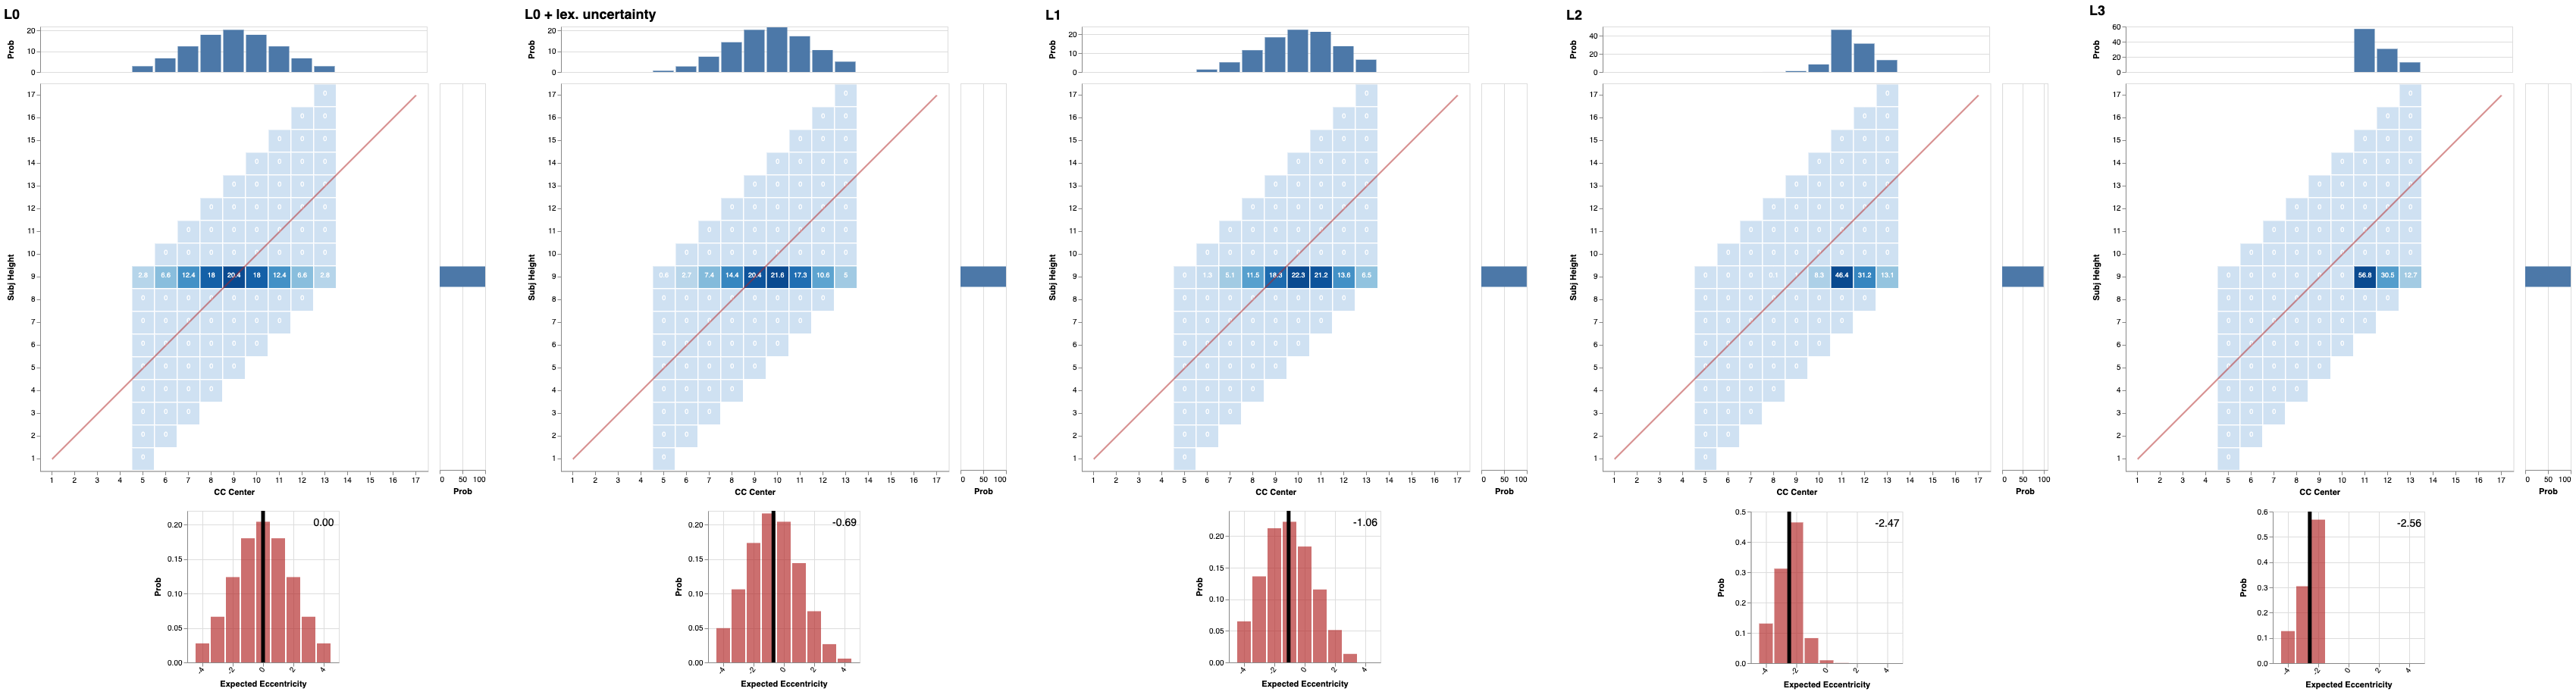

In [33]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUMExact cacheRef (0, UShrt, denExact0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUMExact >>= \l -> listener infoLUMExact cacheRef (0, UShrt, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUMExact cacheRef (1, UShrt, denExact0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUMExact cacheRef (2, UShrt, denExact0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUMExact cacheRef (3, UShrt, denExact0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUMExact cacheRef (0, UShrt, denExact0))
  , ("L0 + lex. uncertainty", lp infoLUMExact>>= \l -> listener infoLUMExact cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMExact cacheRef (1, UShrt, denExact0))
  , ("L2", listener infoLUMExact cacheRef (2, UShrt, denExact0))
  , ("L3", listener infoLUMExact cacheRef (3, UShrt, denExact0))
  ]

## Independent Equative

All adjectival utterances are now interpreted as entailing that Joan's height is equal to Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is Bill-tall}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = b \land b \geq \mu + \sigma\end{equation}

In [35]:
denIEq0 billht = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w == billht) indices
        f UShrt = filter (\(w,i) -> ht w == billht) indices

htsbill = [h | h <- heights, h > sigma, h <= maximum heights - sigma]
-- htsbill = heights

ieqDens :: [Lexicon]
ieqDens = 
  do d <- htrange
     b <- htsbill
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w == b && b >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w == b && b <= i + d) indices
     return (Lex (d * 25 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is as tall as Bill"

Consider a listener that is not settled on one of these stengthenings

In [36]:
infoLUMIEq = infoBaseline {lp = unif ieqDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

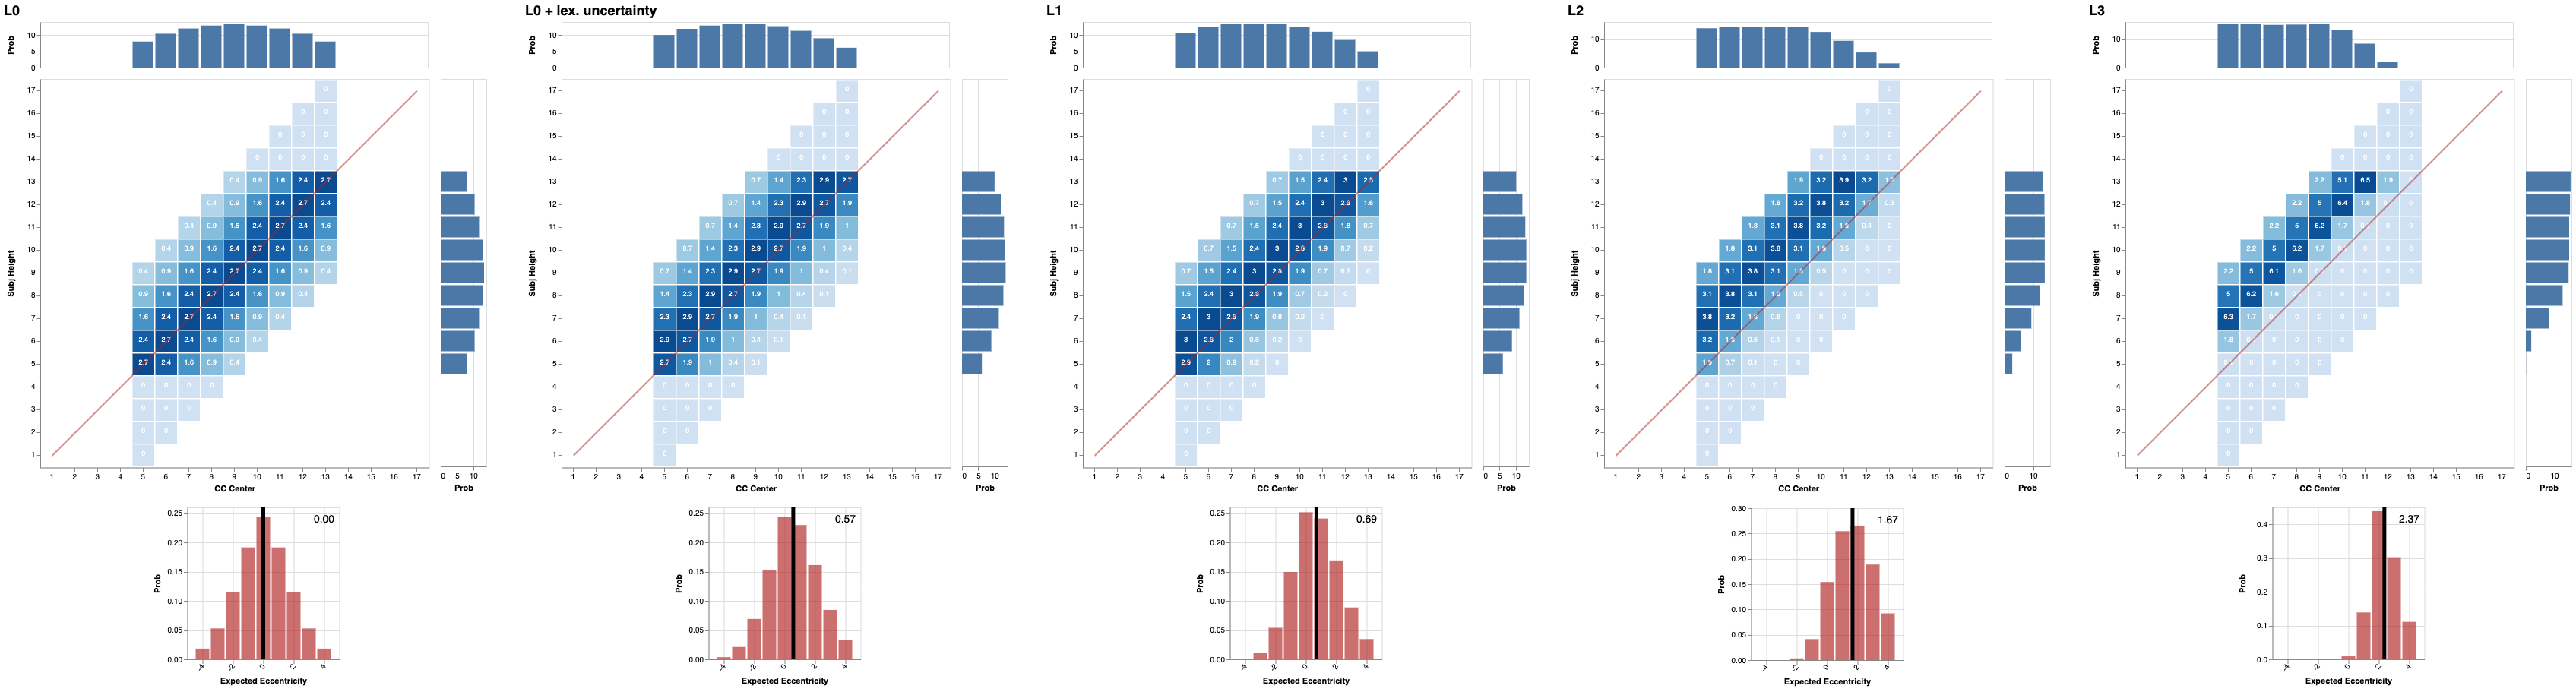

In [37]:
writeIORef cacheRef (0, Map.empty)

mkEqGraph = mkGraph
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMIEq cacheRef (0, UTall, denIEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMIEq >>= \l -> listener infoLUMIEq cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMIEq cacheRef (1, UTall, denIEq0 11))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMIEq cacheRef (2, UTall, denIEq0 11))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMIEq cacheRef (3, UTall, denIEq0 11))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> listener infoLUMIEq cacheRef (0, UTall, denIEq0 n))
  , ("L0 + lex. uncertainty", lp infoLUMIEq >>= \l -> listener infoLUMIEq cacheRef (0, UTall, l))
  , ("L1", listener infoLUMIEq cacheRef (1, UTall, denIEq0 11))
  , ("L2", listener infoLUMIEq cacheRef (2, UTall, denIEq0 11))
  , ("L3", listener infoLUMIEq cacheRef (3, UTall, denIEq0 11))
  ]

#### Pragmatic listener hears:

> "Joan is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

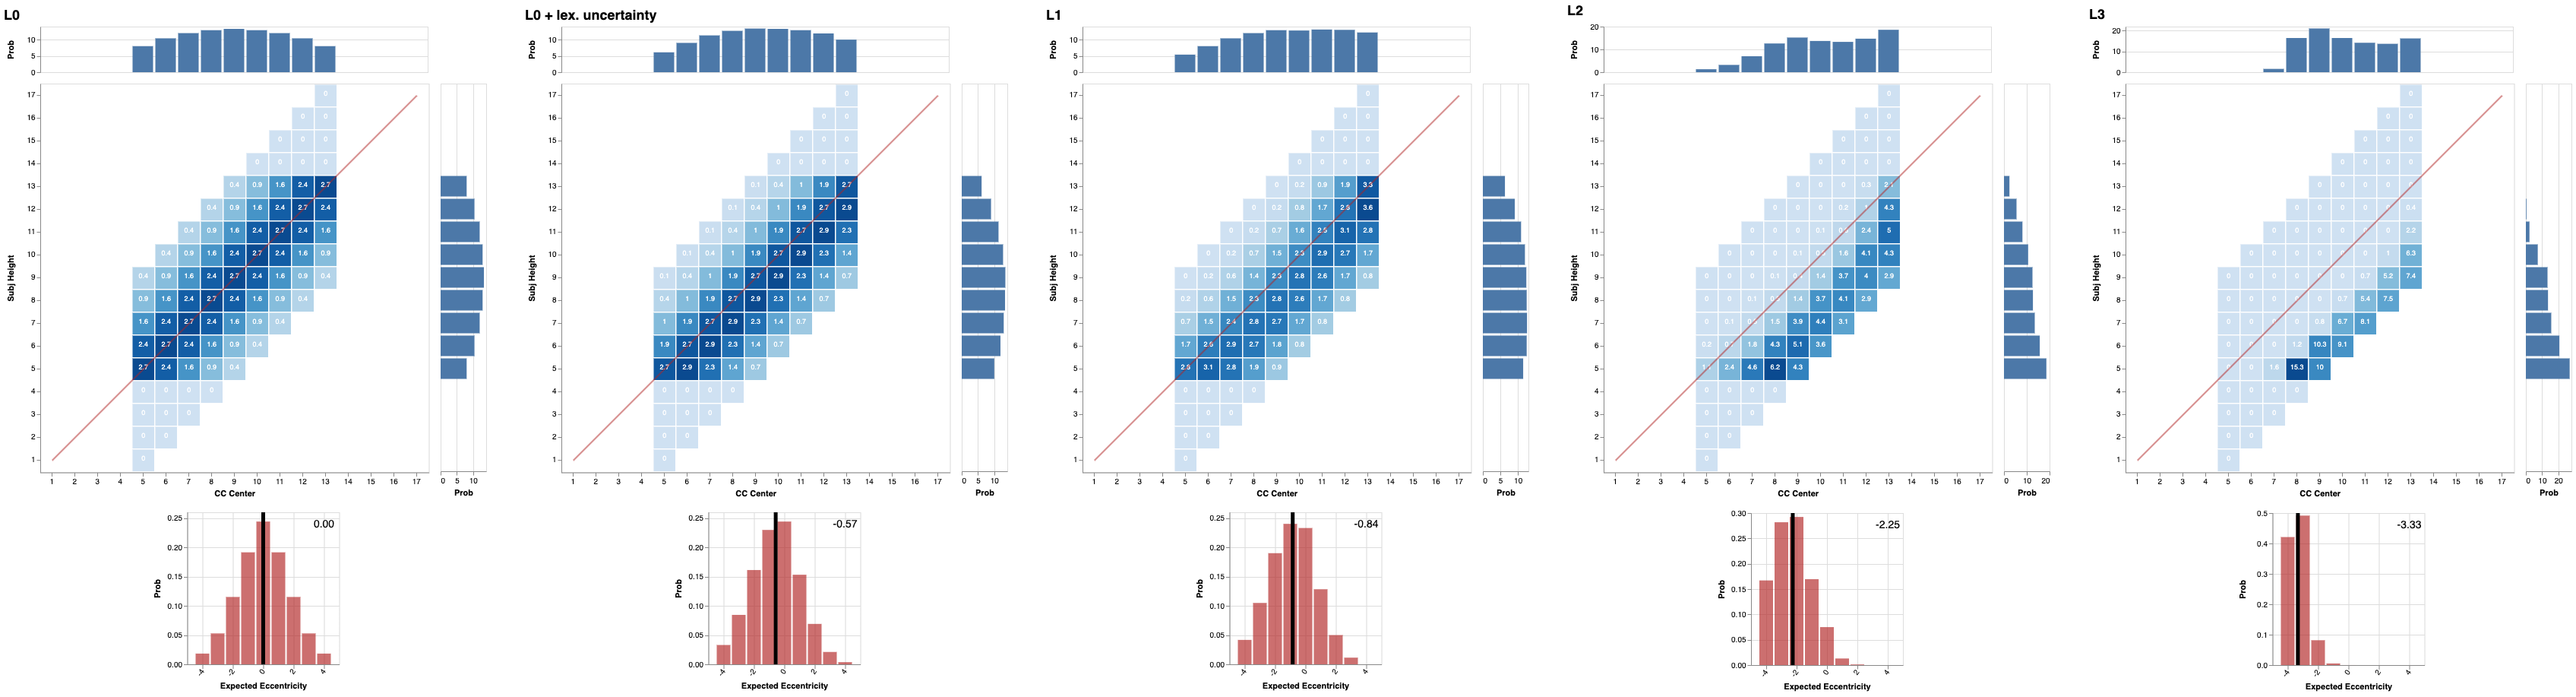

In [38]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMIEq cacheRef (0, UShrt, denIEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMIEq >>= \l -> listener infoLUMIEq cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMIEq cacheRef (1, UShrt, denIEq0 11))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMIEq cacheRef (2, UShrt, denIEq0 11))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMIEq cacheRef (3, UShrt, denIEq0 11))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> listener infoLUMIEq cacheRef (0, UShrt, denIEq0 n))
  , ("L0 + lex. uncertainty", lp infoLUMIEq >>= \l -> listener infoLUMIEq cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMIEq cacheRef (1, UShrt, denIEq0 11))
  , ("L2", listener infoLUMIEq cacheRef (2, UShrt, denIEq0 11))
  , ("L3", listener infoLUMIEq cacheRef (3, UShrt, denIEq0 11))
  ]

## Averaged Equative

All adjectival utterances are now interpreted as entailing that Joan's height is the same as Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is as tall as Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) > b \land b \geq \mu + \sigma\end{equation}
\begin{equation}[\![\text{Joan is as short as Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) < b \land b \leq \mu + \sigma\end{equation}

In [39]:
denAEq0 billht = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w == billht) indices
        f UShrt = filter (\(w,i) -> ht w == billht) indices

-- htsbill = [4 .. 8]
htsbill = heights

aeqDens :: [Lexicon]
aeqDens = 
  do d <- htrange
     b <- htsbill
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w == b && b >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w == b && b <= i + d) indices
     return (Lex (d * 25 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is as tall as Bill"

Consider a listener that is not settled on one of these stengthenings

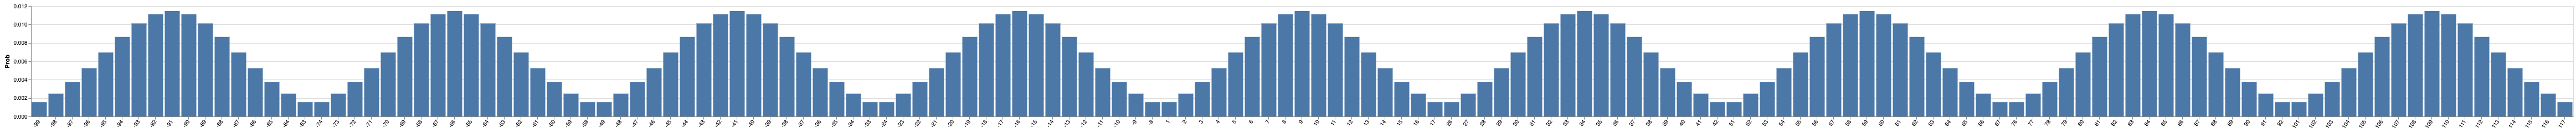

In [40]:
aeqDenPrior = do
  l <- unif aeqDens
  let b = lexID l - maximum [d | d <- fmap (*25) htrange, d < lexID l]
  observe (Normal 9 4.0) (fromIntegral b)
  return l
  
infoLUMAEq = infoBaseline {lp = aeqDenPrior}

-- vlShow . barFromDist <$> enumD (lexID <$> aeqDenPrior)

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

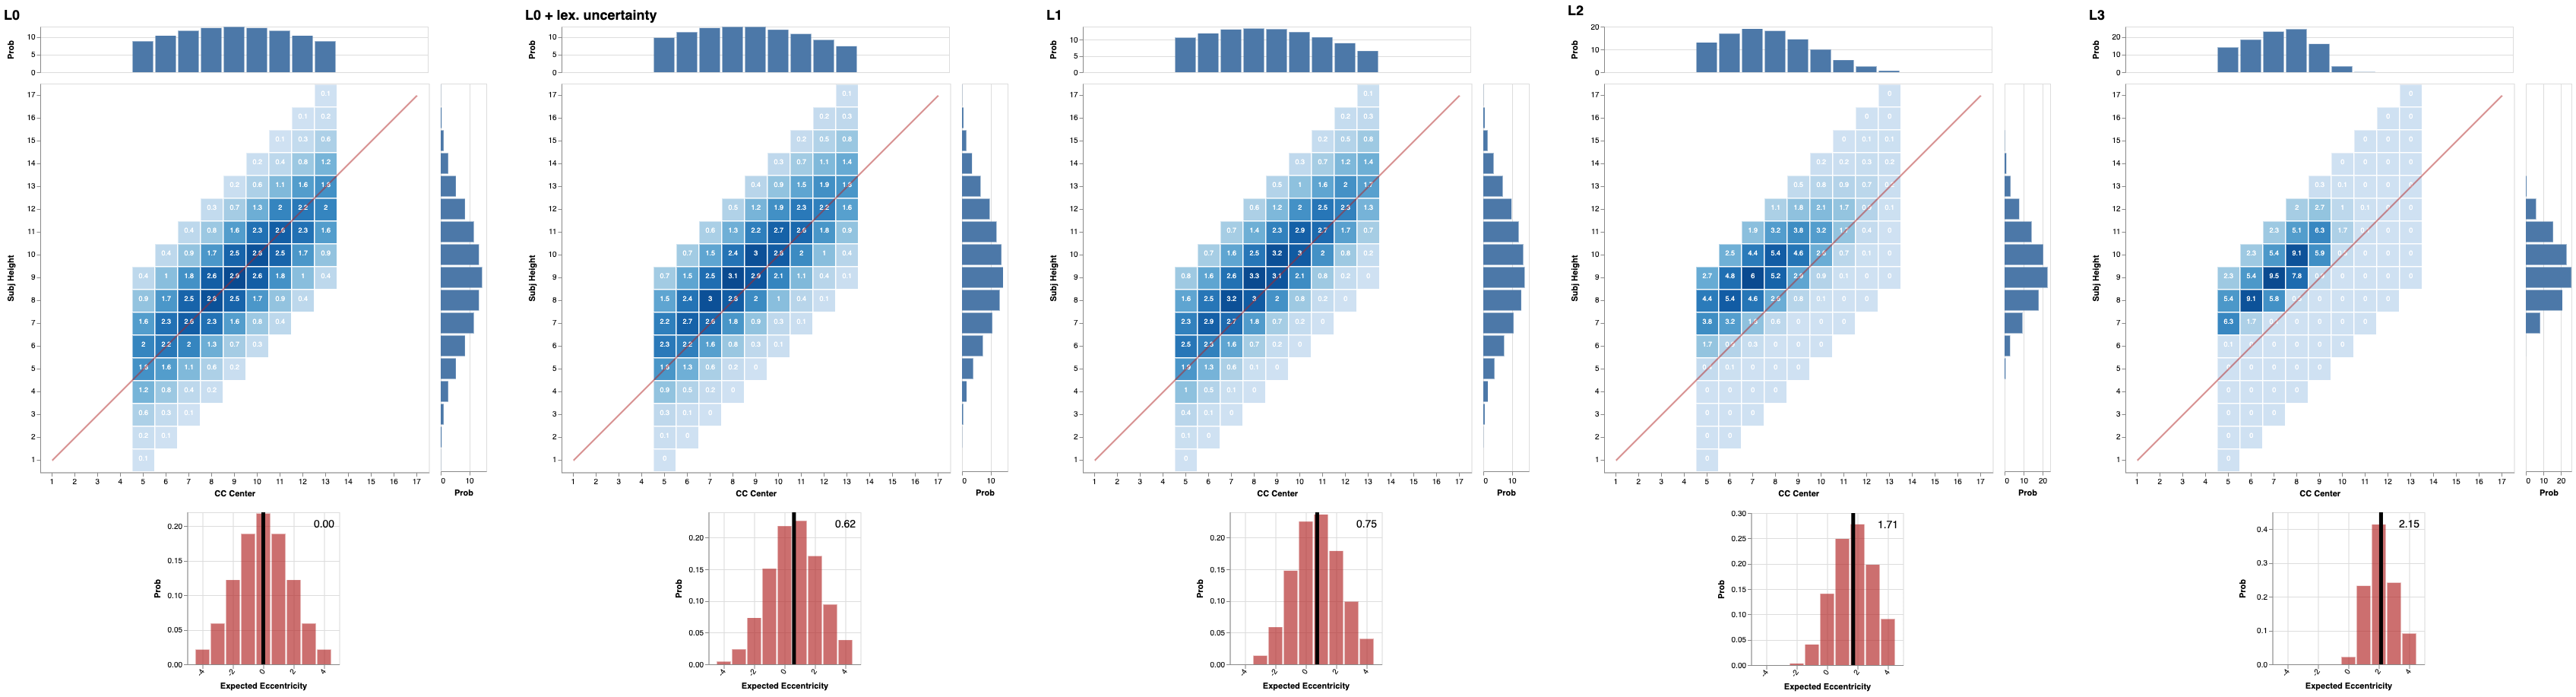

In [41]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMAEq cacheRef (0, UTall, denAEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMAEq >>= \l -> listener infoLUMAEq cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMAEq cacheRef (1, UTall, denAEq0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMAEq cacheRef (2, UTall, denAEq0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMAEq cacheRef (3, UTall, denAEq0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> observe (Normal 9 4.0) (fromIntegral n) >> listener infoLUMAEq cacheRef (0, UTall, denAEq0 n))
  , ("L0 + lex. uncertainty", lp infoLUMAEq >>= \l -> listener infoLUMAEq cacheRef (0, UTall, l))
  , ("L1", listener infoLUMAEq cacheRef (1, UTall, denAEq0 midpoint))
  , ("L2", listener infoLUMAEq cacheRef (2, UTall, denAEq0 midpoint))
  , ("L3", listener infoLUMAEq cacheRef (3, UTall, denAEq0 midpoint))
  ]

#### Pragmatic listener hears:

> "Joan is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

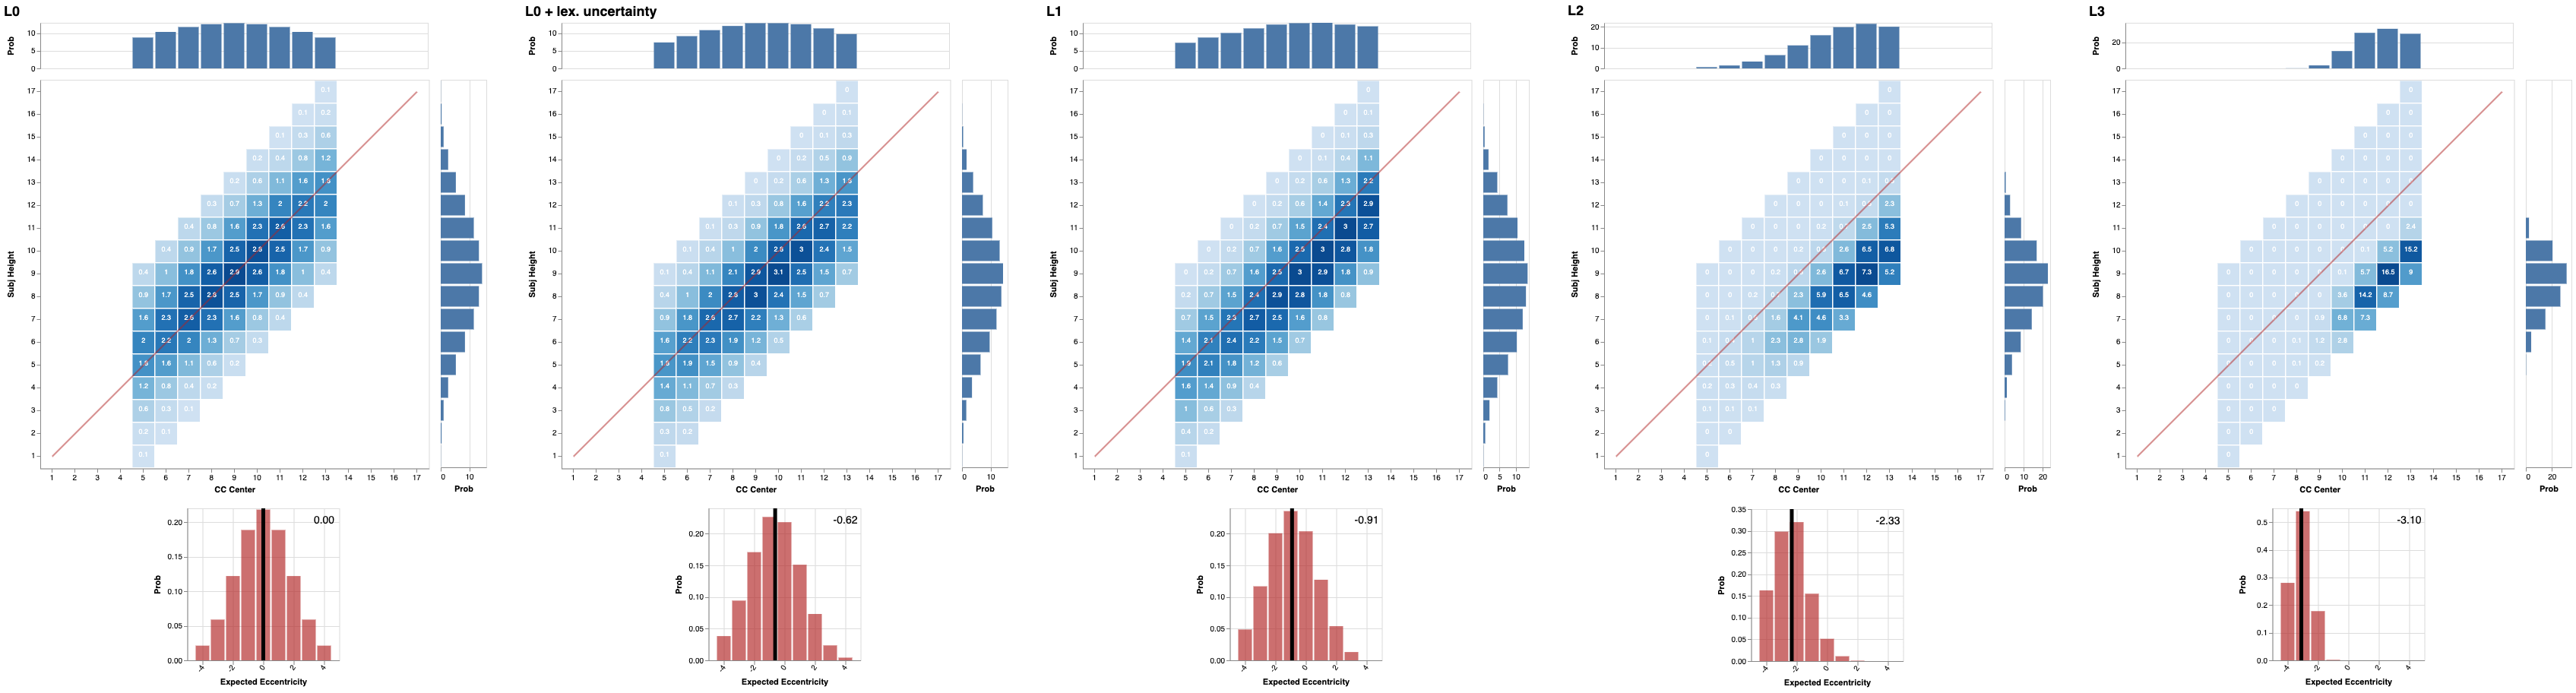

In [42]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMAEq cacheRef (0, UShrt, denAEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMAEq >>= \l -> listener infoLUMAEq cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMAEq cacheRef (1, UShrt, denAEq0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMAEq cacheRef (2, UShrt, denAEq0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMAEq cacheRef (3, UShrt, denAEq0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> observe (Normal 9 4.0) (fromIntegral n) >> listener infoLUMAEq cacheRef (0, UShrt, denAEq0 n))
  , ("L0 + lex. uncertainty", lp infoLUMAEq >>= \l -> listener infoLUMAEq cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMAEq cacheRef (1, UShrt, denAEq0 midpoint))
  , ("L2", listener infoLUMAEq cacheRef (2, UShrt, denAEq0 midpoint))
  , ("L3", listener infoLUMAEq cacheRef (3, UShrt, denAEq0 midpoint))
  ]

## Uncertain Equative

In [43]:
multiverse = [World ("j" ++ show h) h h' | h <- heights, h' <- heights]
indicesEq =
  [ (w, mu)
  | mu <- drop sigma . dropEnd sigma $ heights
  , w <- multiverse
  , abs (ht w - mu) <= sigma
  , abs (foil w - mu) <= sigma
  ]

indicesPriorEq :: Model Index
indicesPriorEq =
  do (w,i) <- unif indicesEq
     observe (Normal 0 2.00) (fromIntegral $ ht w - i)
     observe (Normal 0 2.00) (fromIntegral $ foil w - i)
     return (w,i)

All adjectival utterances are now interpreted as entailing that Joan's height is equal to Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is as tall as Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = b \land b \geq \mu + \sigma\end{equation}

In [44]:
denEq0 _ = Lex 0 f
  where f UNone = indicesEq
        f UTall = filter (\(w,i) -> ht w == foil w) indicesEq
        f UShrt = filter (\(w,i) -> ht w == foil w) indicesEq
        
eqDens :: [Lexicon]
eqDens = 
  do d <- htrange
     let f UNone = indicesEq
         f UTall = filter (\(w,i) -> ht w == foil w && foil w >= i + d) indicesEq
         f UShrt = filter (\(w,i) -> ht w == foil w && foil w <= i + d) indicesEq
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is as tall as Bill"

Consider a listener that is not settled on one of these stengthenings

In [45]:
infoLUMEq = infoBaseline {ip = indicesPriorEq, lp = unif eqDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

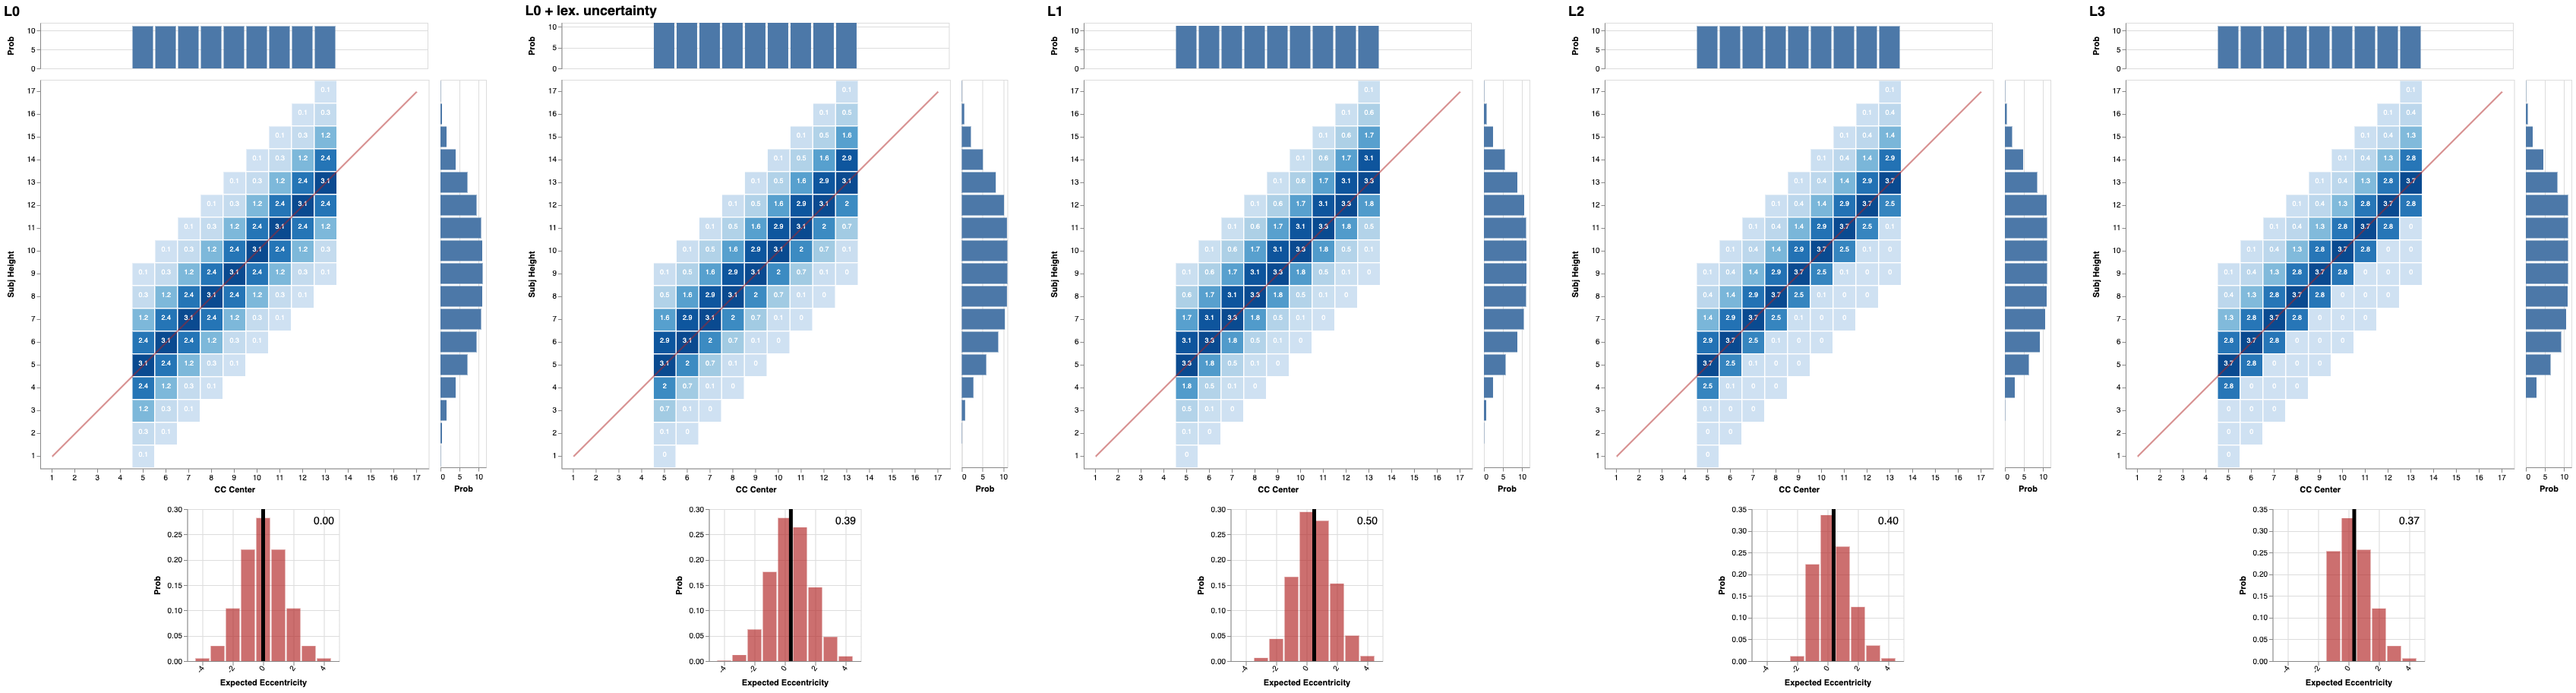

In [46]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMEq cacheRef (0, UTall, denEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMEq cacheRef (1, UTall, denEq0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMEq cacheRef (2, UTall, denEq0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMEq cacheRef (3, UTall, denEq0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
--   [ ("L0", unif htsbill >>= \n -> listener infoLUMEq cacheRef (0, UTall, denEq0 n))
  [ ("L0", listener infoLUMEq cacheRef (0, UTall, denEq0 midpoint))
  , ("L0 + lex. uncertainty", lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UTall, l))
  , ("L1", listener infoLUMEq cacheRef (1, UTall, denEq0 midpoint))
  , ("L2", listener infoLUMEq cacheRef (2, UTall, denEq0 midpoint))
  , ("L3", listener infoLUMEq cacheRef (3, UTall, denEq0 midpoint))
  ]

#### Pragmatic listener hears:

> "Joan is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

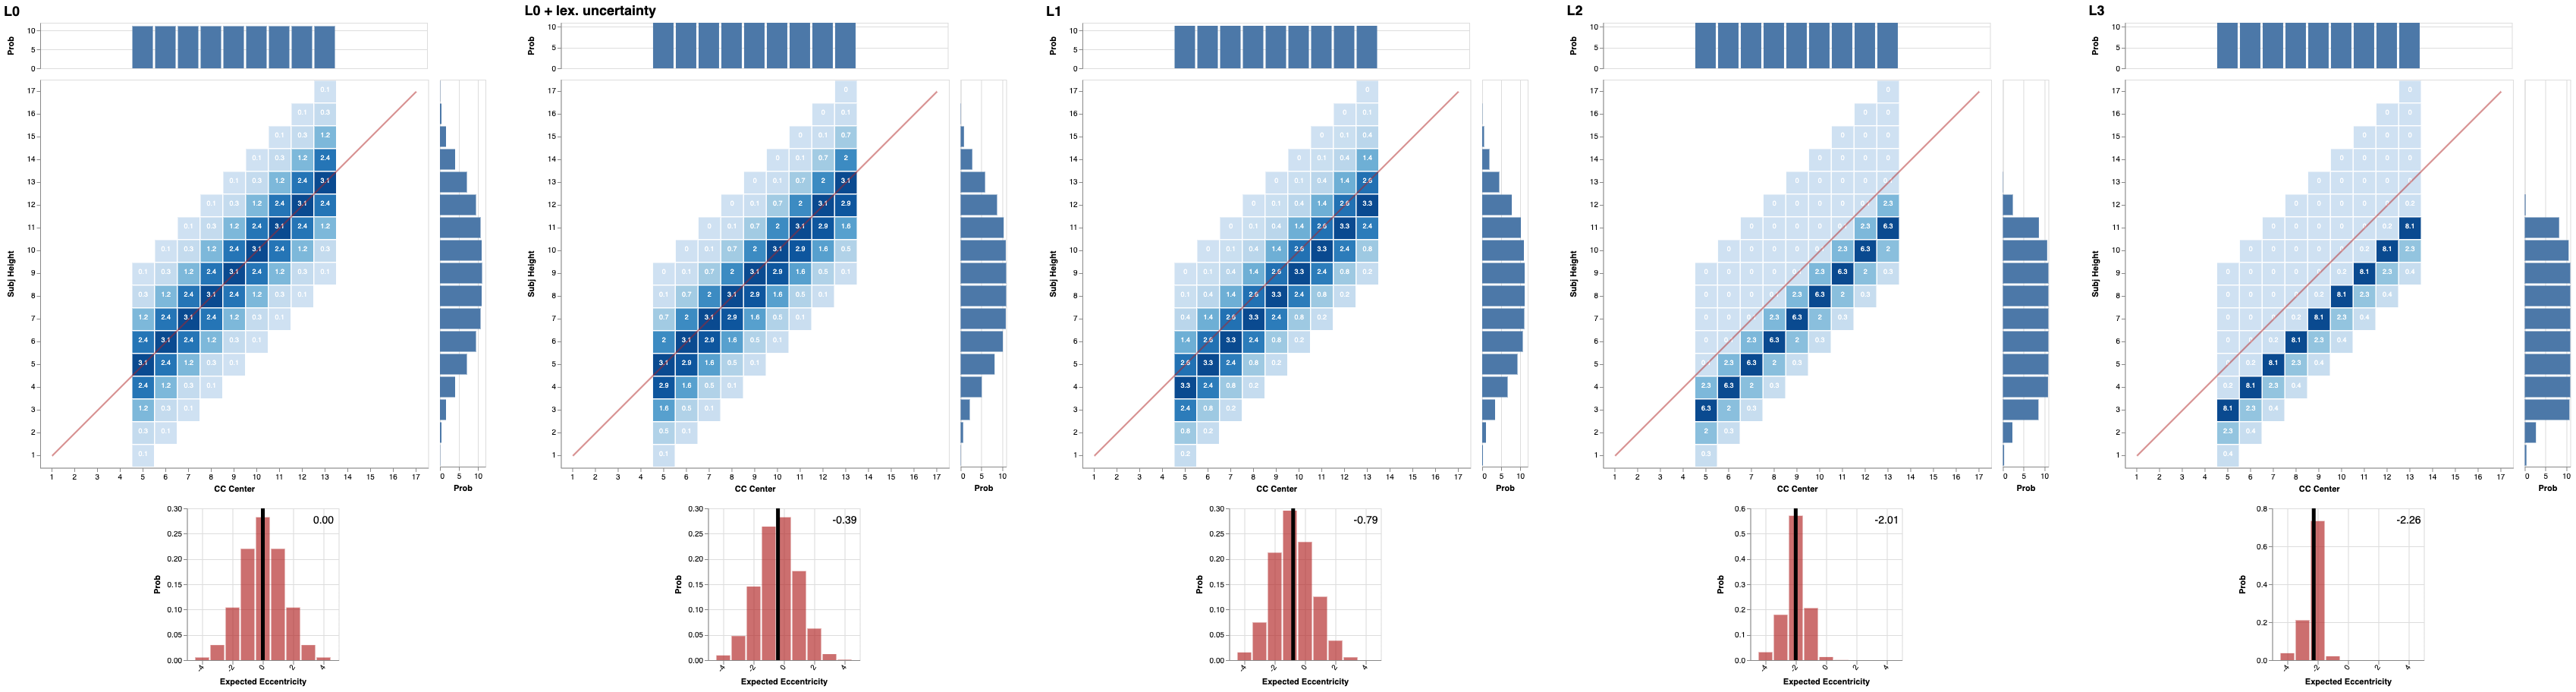

In [47]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMEq cacheRef (0, UShrt, denEq0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMEq cacheRef (1, UShrt, denEq0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMEq cacheRef (2, UShrt, denEq0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMEq cacheRef (3, UShrt, denEq0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
--   [ ("L0", unif htsbill >>= \n -> listener infoLUMEq cacheRef (0, UShrt, denEq0 n))
  [ ("L0", listener infoLUMEq cacheRef (0, UShrt, denEq0 midpoint))
  , ("L0 + lex. uncertainty", lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMEq cacheRef (1, UShrt, denEq0 midpoint))
  , ("L2", listener infoLUMEq cacheRef (2, UShrt, denEq0 midpoint))
  , ("L3", listener infoLUMEq cacheRef (3, UShrt, denEq0 midpoint))
  ]

## Certain Comparative

All adjectival utterances are now interpreted as entailing that Joan's height is greater than Bill's, which is known to be 6

In the baseline lexicon `denKCmp`, this is all that is contributed by an utterance

Other interpretations place Joan's height above Bill's, and additionally guarantee that Bill's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is taller than Bill}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) > b \land b \geq \mu + \sigma\end{equation}
\begin{equation}[\![\text{Joan is shorter than Bill}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) < b \land b \leq \mu + \sigma\end{equation}

In [48]:
denKCmp0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w > midpoint) indices
        f UShrt = filter (\(w,i) -> ht w < midpoint) indices

kcmpDens :: [Lexicon]
kcmpDens = 
  do d <- htrange
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w > midpoint && midpoint >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w < midpoint && midpoint <= i + d) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; Joan is taller than Bill"

Consider a listener that is not settled on one of these stengthenings

In [49]:
infoLUMKCmp = infoBaseline {lp = unif kcmpDens}

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone like Joan (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

So to the extent that this is an evaluative conclusion, it is very weak

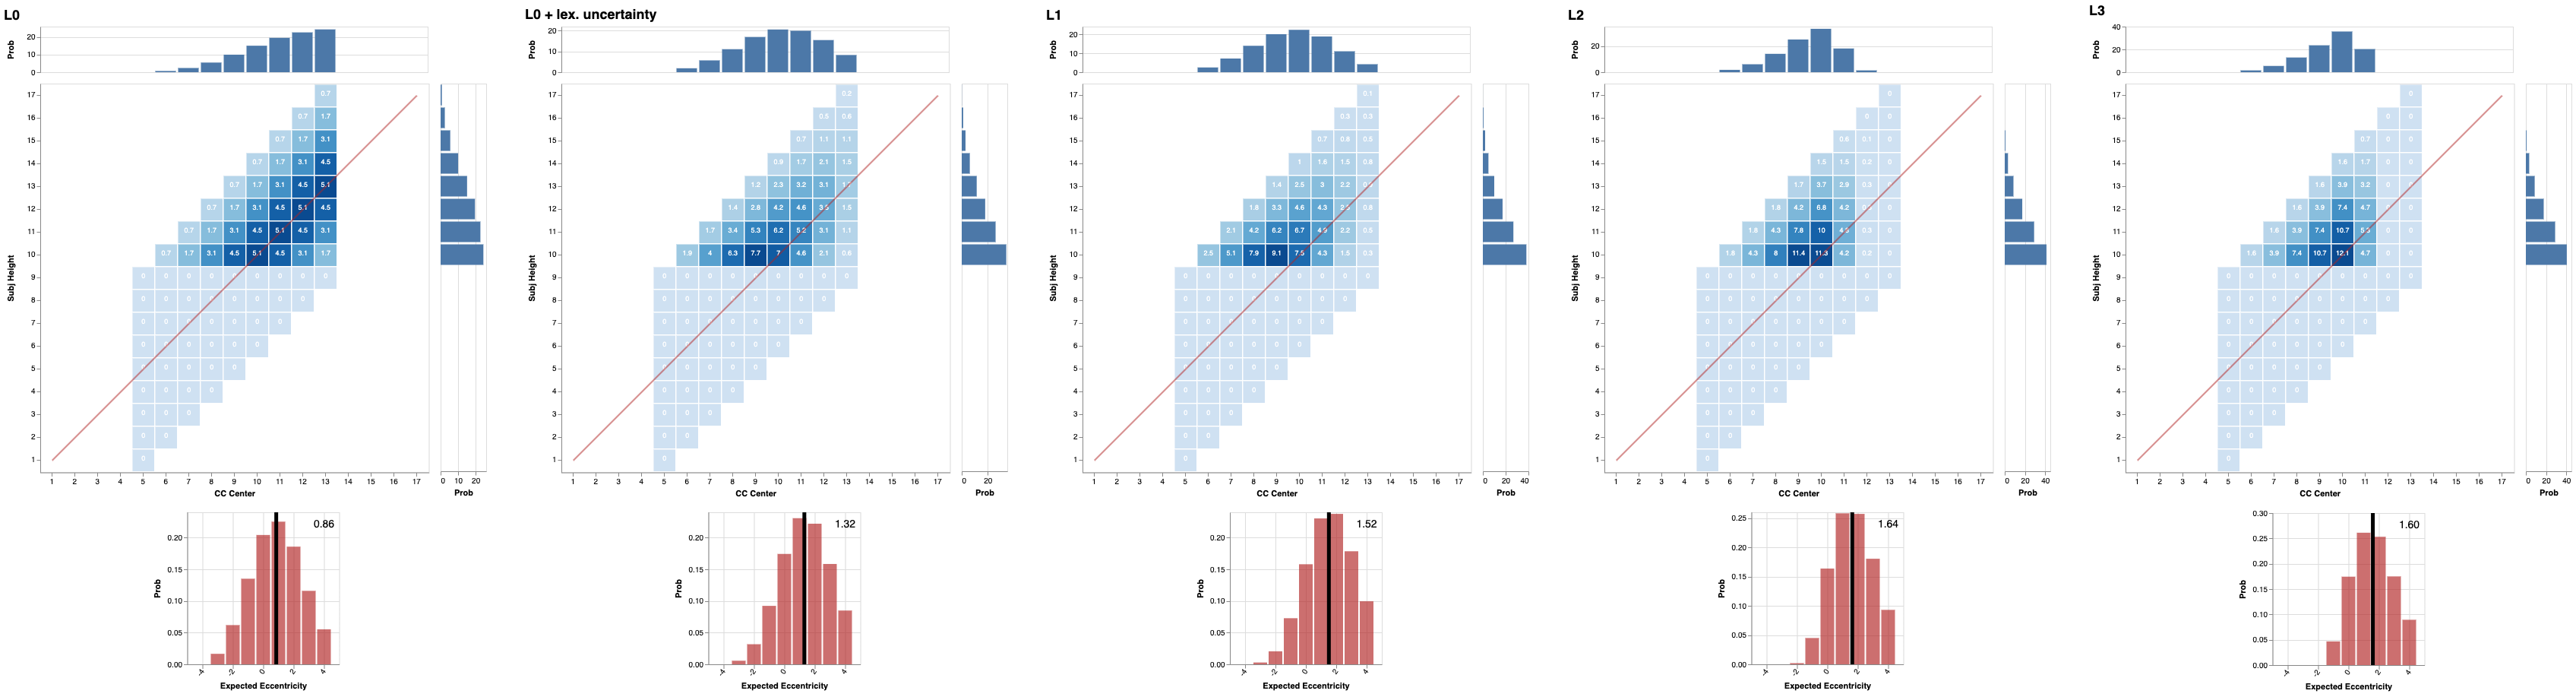

In [50]:
writeIORef cacheRef (0, Map.empty)
 
-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUMKCmp cacheRef (0, UTall, denKCmp0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUMKCmp >>= \l -> listener infoLUMKCmp cacheRef (0, UTall, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUMKCmp cacheRef (1, UTall, denKCmp0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUMKCmp cacheRef (2, UTall, denKCmp0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUMKCmp cacheRef (3, UTall, denKCmp0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUMKCmp cacheRef (0, UTall, denKCmp0))
  , ("L0 + lex. uncertainty", lp infoLUMKCmp>>= \l -> listener infoLUMKCmp cacheRef (0, UTall, l))
  , ("L1", listener infoLUMKCmp cacheRef (1, UTall, denKCmp0))
  , ("L2", listener infoLUMKCmp cacheRef (2, UTall, denKCmp0))
  , ("L3", listener infoLUMKCmp cacheRef (3, UTall, denKCmp0))
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; Joan is shorter than Bill"

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

So again the evaluativity effect is much stronger

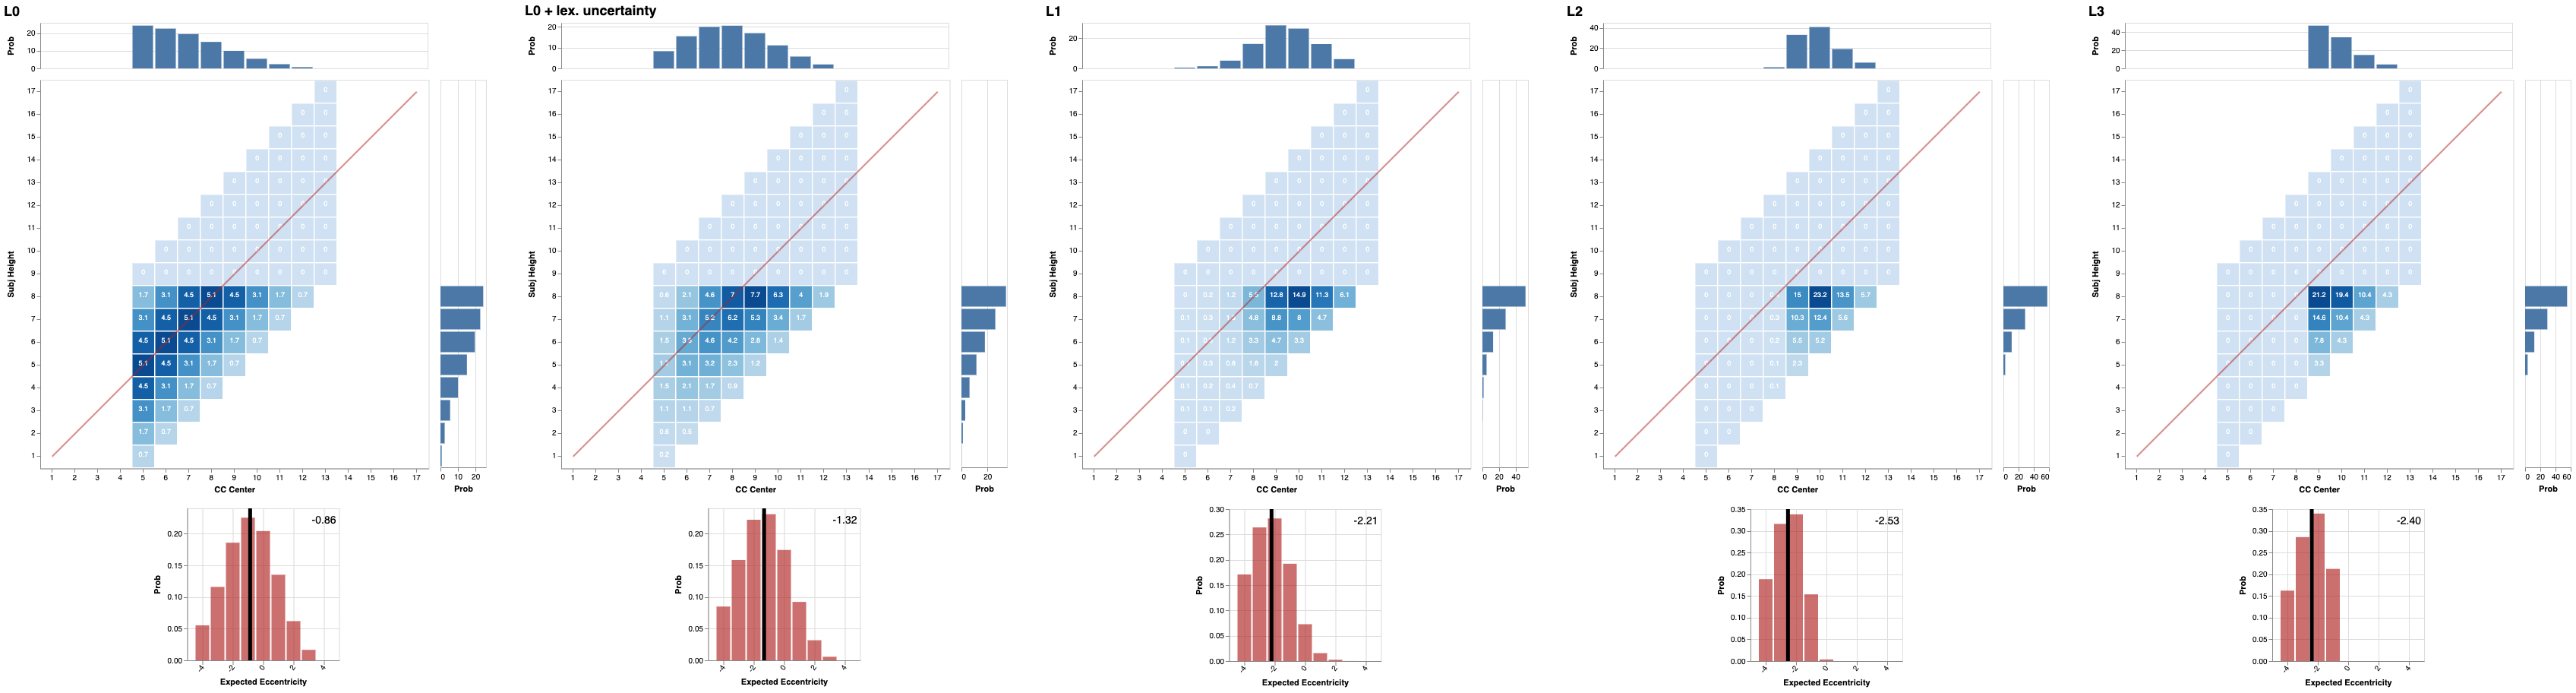

In [51]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkGraph ("L0 literal listener", listener infoLUMKCmp cacheRef (0, UShrt, denKCmp0))
-- vlShow <$> mkGraph ("L0 + lex. uncertainty", lp infoLUMKCmp >>= \l -> listener infoLUMKCmp cacheRef (0, UShrt, l))
-- vlShow <$> mkGraph ("L1 pragmatic listener", listener infoLUMKCmp cacheRef (1, UShrt, denKCmp0))
-- vlShow <$> mkGraph ("L2 pragmatic listener", listener infoLUMKCmp cacheRef (2, UShrt, denKCmp0))
-- vlShow <$> mkGraph ("L3 pragmatic listener", listener infoLUMKCmp cacheRef (3, UShrt, denKCmp0))
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ ("L0", listener infoLUMKCmp cacheRef (0, UShrt, denKCmp0))
  , ("L0 + lex. uncertainty", lp infoLUMKCmp>>= \l -> listener infoLUMKCmp cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMKCmp cacheRef (1, UShrt, denKCmp0))
  , ("L2", listener infoLUMKCmp cacheRef (2, UShrt, denKCmp0))
  , ("L3", listener infoLUMKCmp cacheRef (3, UShrt, denKCmp0))
  ]

## Independent Comparative

All adjectival utterances are now interpreted as entailing that Joan's height is greater than Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is taller than Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = b \land b \geq \mu + \sigma\end{equation}

In [52]:
denICmp0 billht = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w > billht) indices
        f UShrt = filter (\(w,i) -> ht w < billht) indices

htsbill = [h | h <- heights, h > sigma, h <= maximum heights - sigma]
-- htsbill = heights

icmpDens :: [Lexicon]
icmpDens = 
  do d <- htrange
     b <- htsbill
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w > b && b >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w < b && b <= i + d) indices
     return (Lex (d * 25 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is taller than Bill"

Consider a listener that is not settled on one of these stengthenings

In [53]:
infoLUMICmp = infoBaseline {lp = unif icmpDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

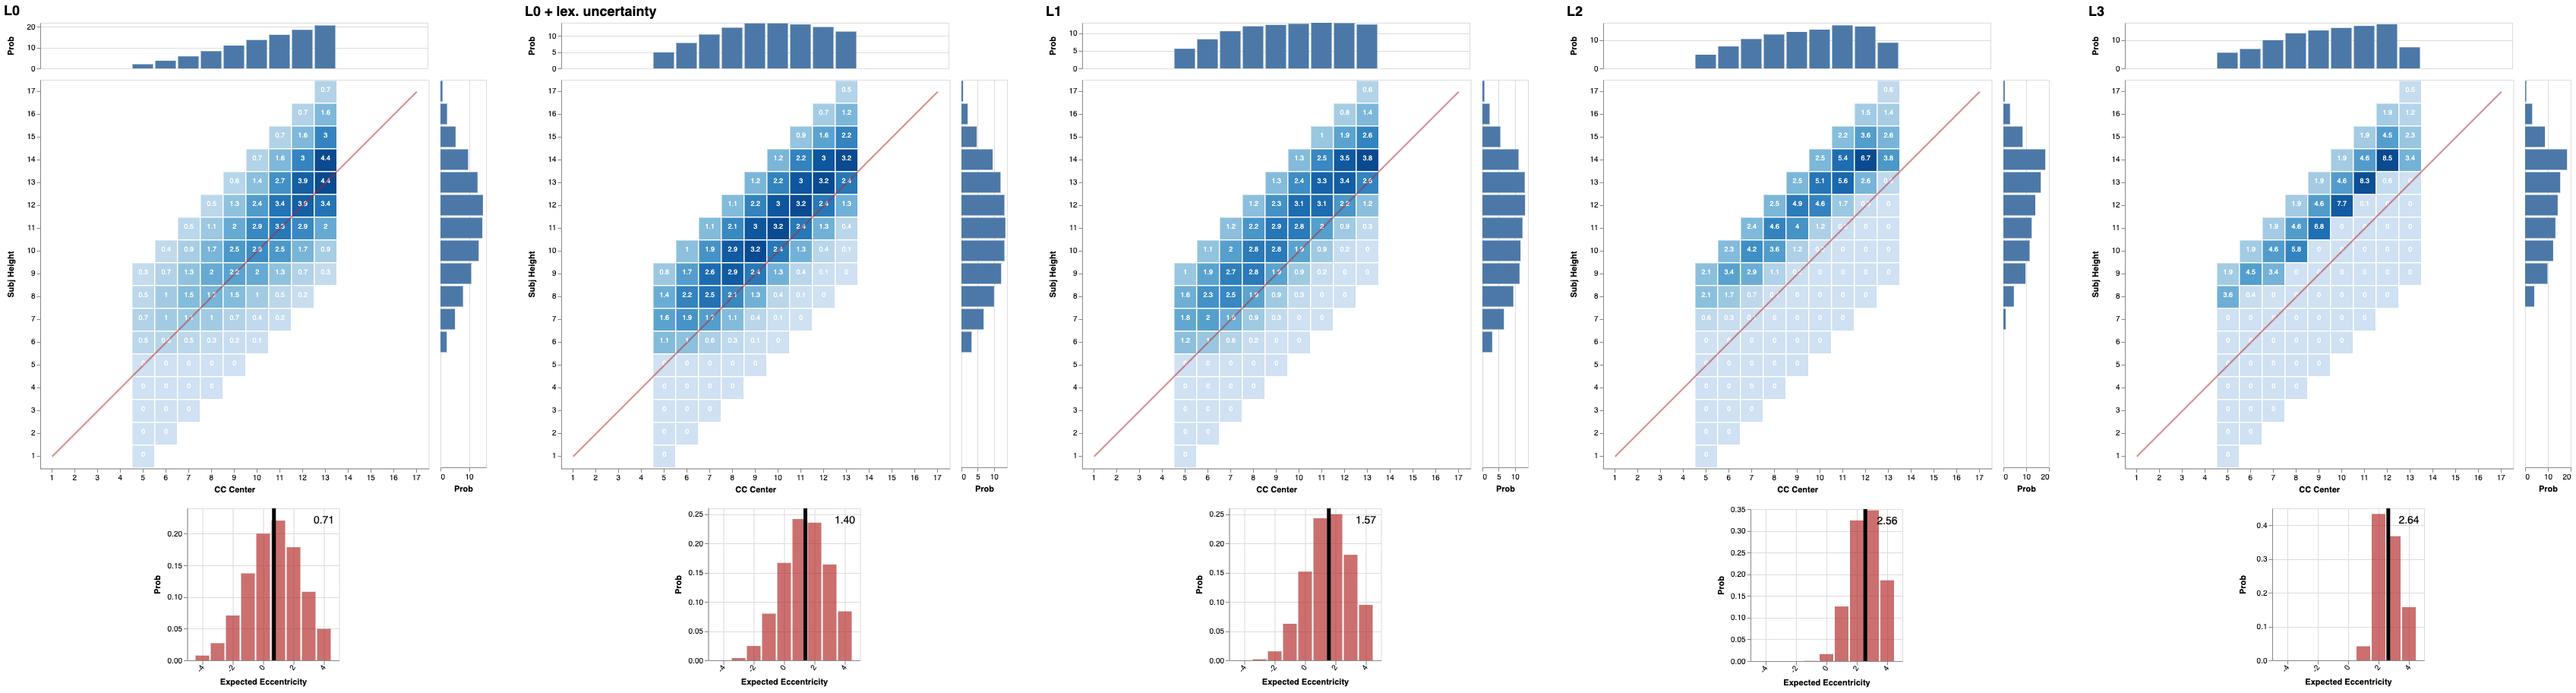

In [54]:
writeIORef cacheRef (0, Map.empty)
 
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMICmp cacheRef (0, UTall, denICmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMICmp >>= \l -> listener infoLUMICmp cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMICmp cacheRef (1, UTall, denICmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMICmp cacheRef (2, UTall, denICmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMICmp cacheRef (3, UTall, denICmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> listener infoLUMICmp cacheRef (0, UTall, denICmp0 n))
  , ("L0 + lex. uncertainty", lp infoLUMICmp >>= \l -> listener infoLUMICmp cacheRef (0, UTall, l))
  , ("L1", listener infoLUMICmp cacheRef (1, UTall, denICmp0 midpoint))
  , ("L2", listener infoLUMICmp cacheRef (2, UTall, denICmp0 midpoint))
  , ("L3", listener infoLUMICmp cacheRef (3, UTall, denICmp0 midpoint))
  ]

#### Pragmatic listener hears:

> "Joan is shorter than Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

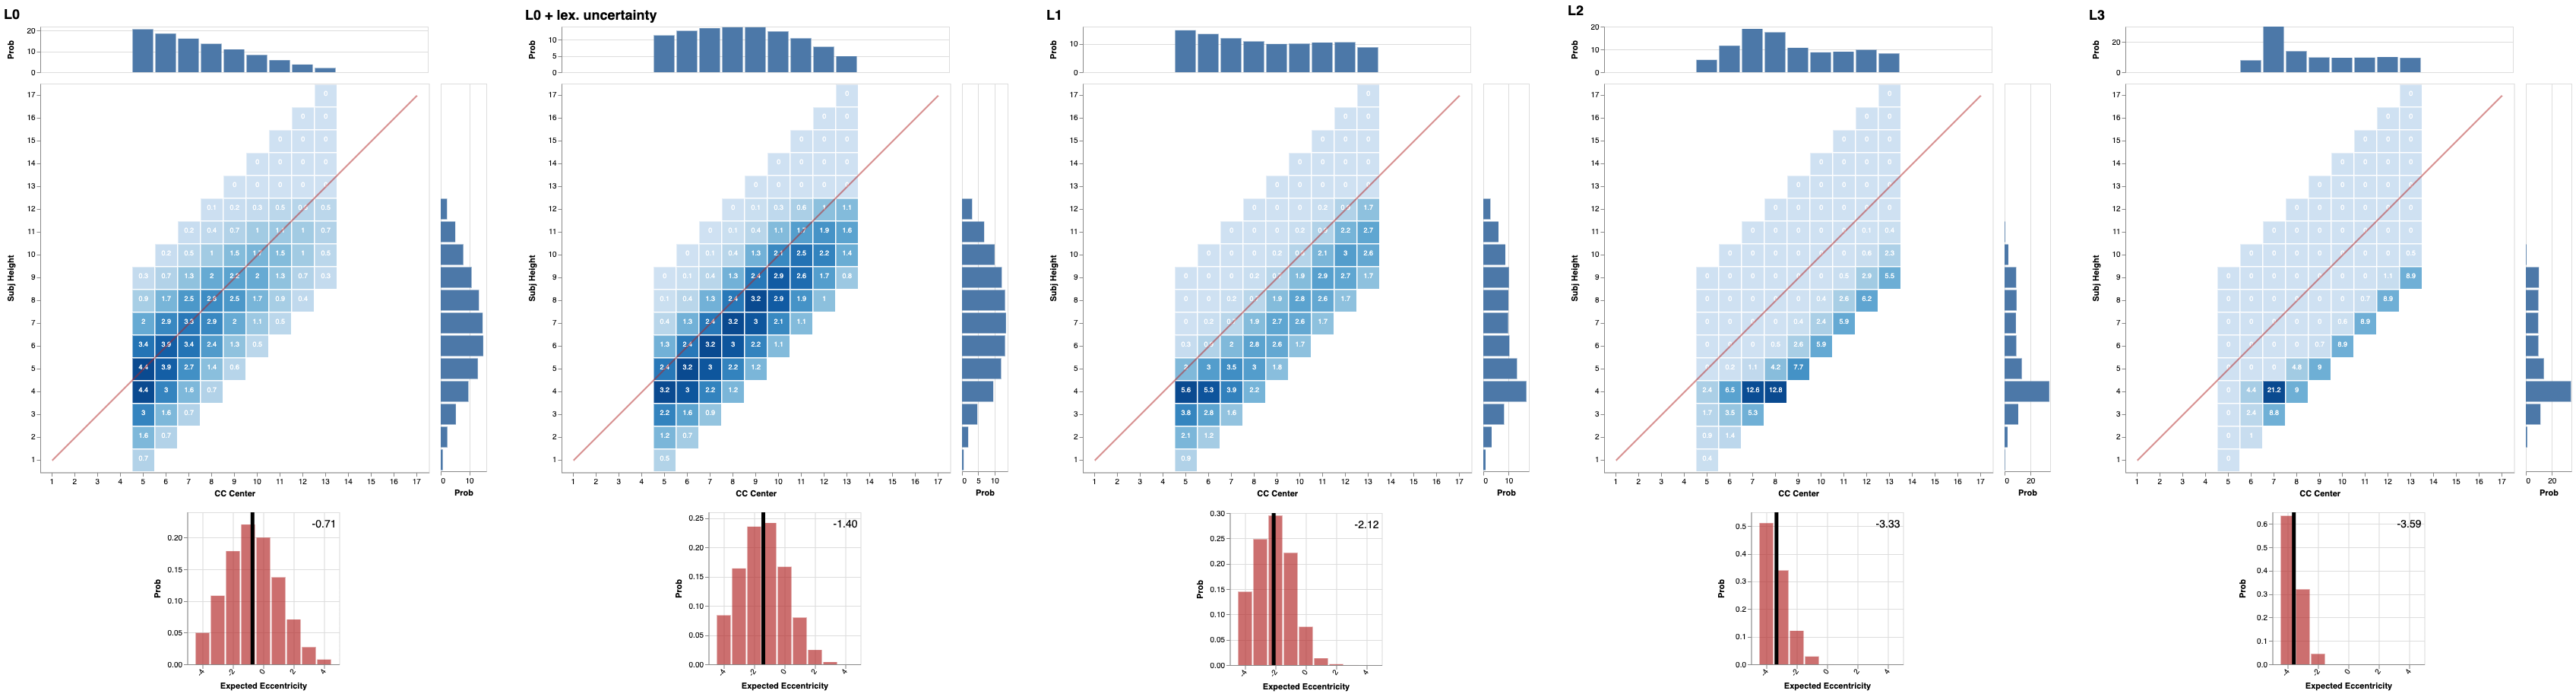

In [55]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMICmp cacheRef (0, UShrt, denICmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMICmp >>= \l -> listener infoLUMICmp cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMICmp cacheRef (1, UShrt, denICmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMICmp cacheRef (2, UShrt, denICmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMICmp cacheRef (3, UShrt, denICmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> listener infoLUMICmp cacheRef (0, UShrt, denICmp0 n))
  , ("L0 + lex. uncertainty", lp infoLUMICmp >>= \l -> listener infoLUMICmp cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMICmp cacheRef (1, UShrt, denICmp0 midpoint))
  , ("L2", listener infoLUMICmp cacheRef (2, UShrt, denICmp0 midpoint))
  , ("L3", listener infoLUMICmp cacheRef (3, UShrt, denICmp0 midpoint))
  ]

## Averaged Comparative

All adjectival utterances are now interpreted as entailing that Joan's height is greater than Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is taller than Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) > b \land b \geq \mu + \sigma\end{equation}
\begin{equation}[\![\text{Joan is shorter than Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) < b \land b \leq \mu + \sigma\end{equation}

In [56]:
denACmp0 billht = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w > billht) indices
        f UShrt = filter (\(w,i) -> ht w < billht) indices

-- htsbill = [4 .. 8]
htsbill = heights

acmpDens :: [Lexicon]
acmpDens = 
  do d <- htrange
     b <- htsbill
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w > b && b >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w < b && b <= i + d) indices
     return (Lex (d * 25 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is taller than Bill"

Consider a listener that is not settled on one of these stengthenings

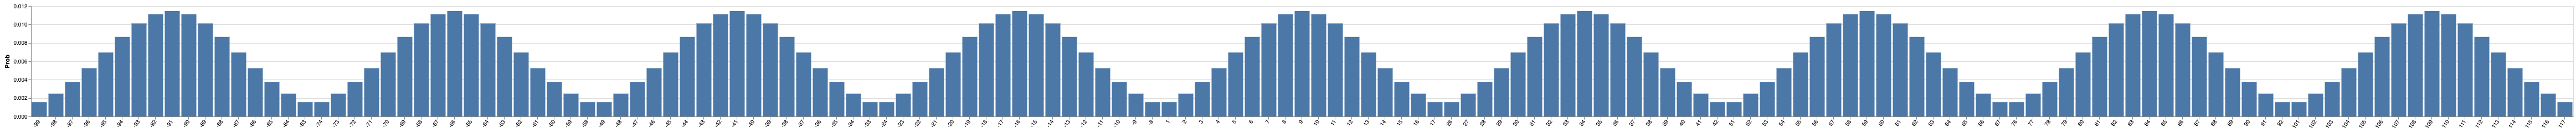

In [57]:
acmpDenPrior = do
  l <- unif acmpDens
  let b = lexID l - maximum [d | d <- fmap (*25) htrange, d < lexID l]
  observe (Normal 9 4.0) (fromIntegral b)
  return l
  
infoLUMACmp = infoBaseline {lp = acmpDenPrior}

vlShow . barFromDist <$> enumD (lexID <$> aeqDenPrior)

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

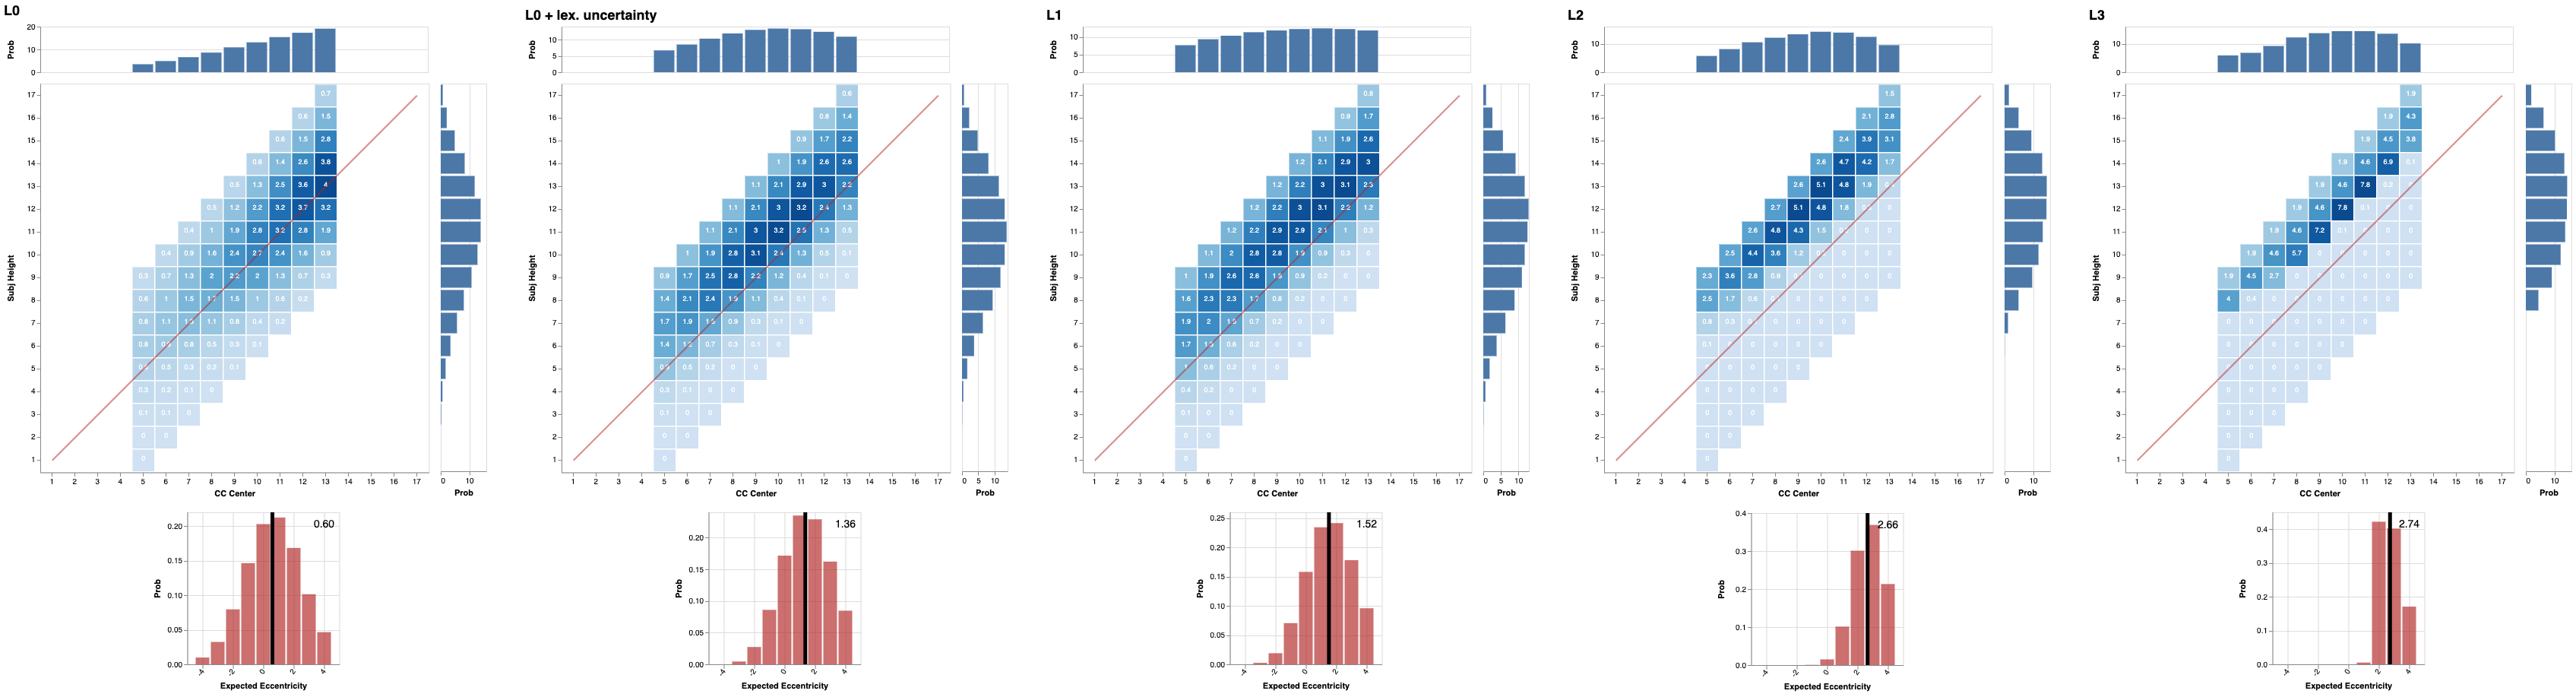

In [58]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMACmp cacheRef (0, UTall, denACmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMACmp >>= \l -> listener infoLUMACmp cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMACmp cacheRef (1, UTall, denACmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMACmp cacheRef (2, UTall, denACmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMACmp cacheRef (3, UTall, denACmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> observe (Normal 9 4.0) (fromIntegral n) >> listener infoLUMACmp cacheRef (0, UTall, denACmp0 n))
  , ("L0 + lex. uncertainty", lp infoLUMACmp >>= \l -> listener infoLUMACmp cacheRef (0, UTall, l))
  , ("L1", listener infoLUMACmp cacheRef (1, UTall, denACmp0 midpoint))
  , ("L2", listener infoLUMACmp cacheRef (2, UTall, denACmp0 midpoint))
  , ("L3", listener infoLUMACmp cacheRef (3, UTall, denACmp0 midpoint))
  ]

#### Pragmatic listener hears:

> "Joan is shorter than Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

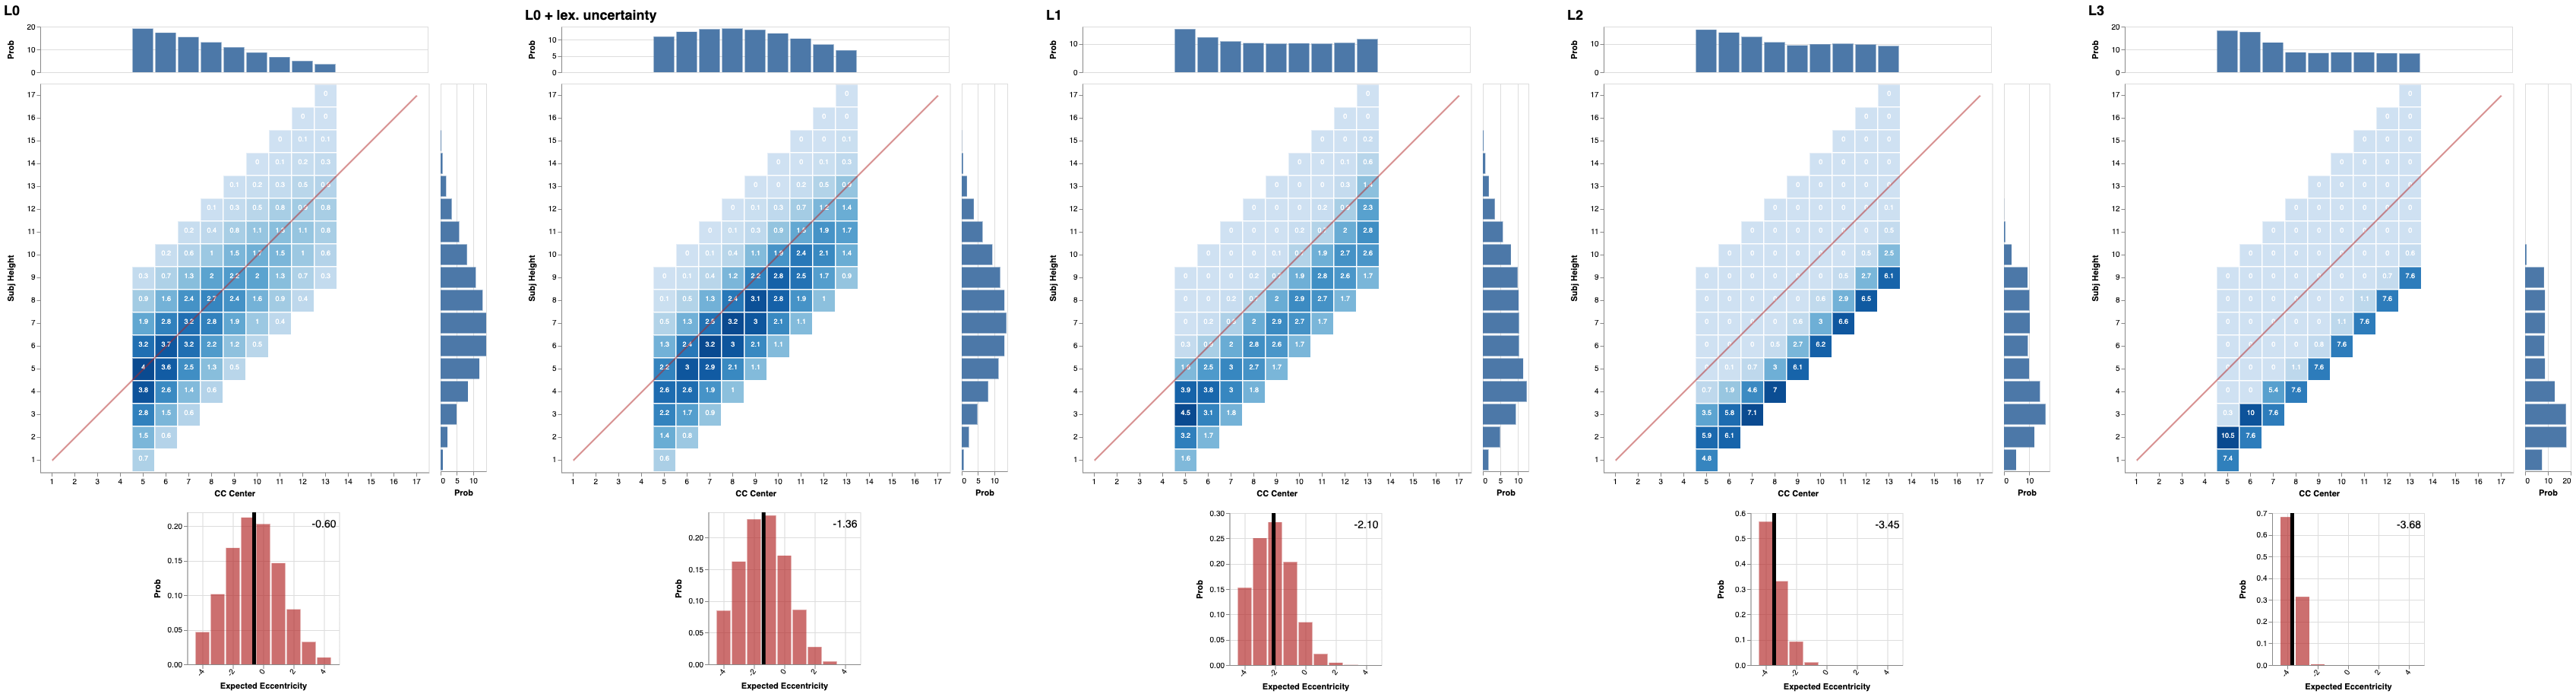

In [59]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMACmp cacheRef (0, UShrt, denACmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMACmp >>= \l -> listener infoLUMACmp cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMACmp cacheRef (1, UShrt, denACmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMACmp cacheRef (2, UShrt, denACmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMACmp cacheRef (3, UShrt, denACmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ ("L0", unif htsbill >>= \n -> observe (Normal 9 4.0) (fromIntegral n) >> listener infoLUMACmp cacheRef (0, UShrt, denACmp0 n))
  , ("L0 + lex. uncertainty", lp infoLUMACmp >>= \l -> listener infoLUMACmp cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMACmp cacheRef (1, UShrt, denACmp0 midpoint))
  , ("L2", listener infoLUMACmp cacheRef (2, UShrt, denACmp0 midpoint))
  , ("L3", listener infoLUMACmp cacheRef (3, UShrt, denACmp0 midpoint))
  ]

## Uncertain Comparative

All adjectival utterances are now interpreted as entailing that Joan's height is greater than Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, so even the literal listener will have to average over guesses about Bill

Other interpretations place Joan's height at other values, and additionally guarantee that Joan's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Joan is taller than Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) > b \land b \geq \mu + \sigma\end{equation}
\begin{equation}[\![\text{Joan is shorter than Bill}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) < b \land b \leq \mu + \sigma\end{equation}

In [60]:
denCmp0 _ = Lex 0 f
  where f UNone = indicesEq
        f UTall = filter (\(w,i) -> ht w > foil w) indicesEq
        f UShrt = filter (\(w,i) -> ht w < foil w) indicesEq
        
cmpDens :: [Lexicon]
cmpDens = 
  do d <- htrange
     let f UNone = indicesEq
         f UTall = filter (\(w,i) -> ht w > foil w && foil w >= i + d) indicesEq
         f UShrt = filter (\(w,i) -> ht w < foil w && foil w <= i + d) indicesEq
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Joan is taller than Bill"

Consider a listener that is not settled on one of these stengthenings

In [61]:
infoLUMCmp = infoBaseline {ip = indicesPriorEq, lp = unif cmpDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that Joan is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

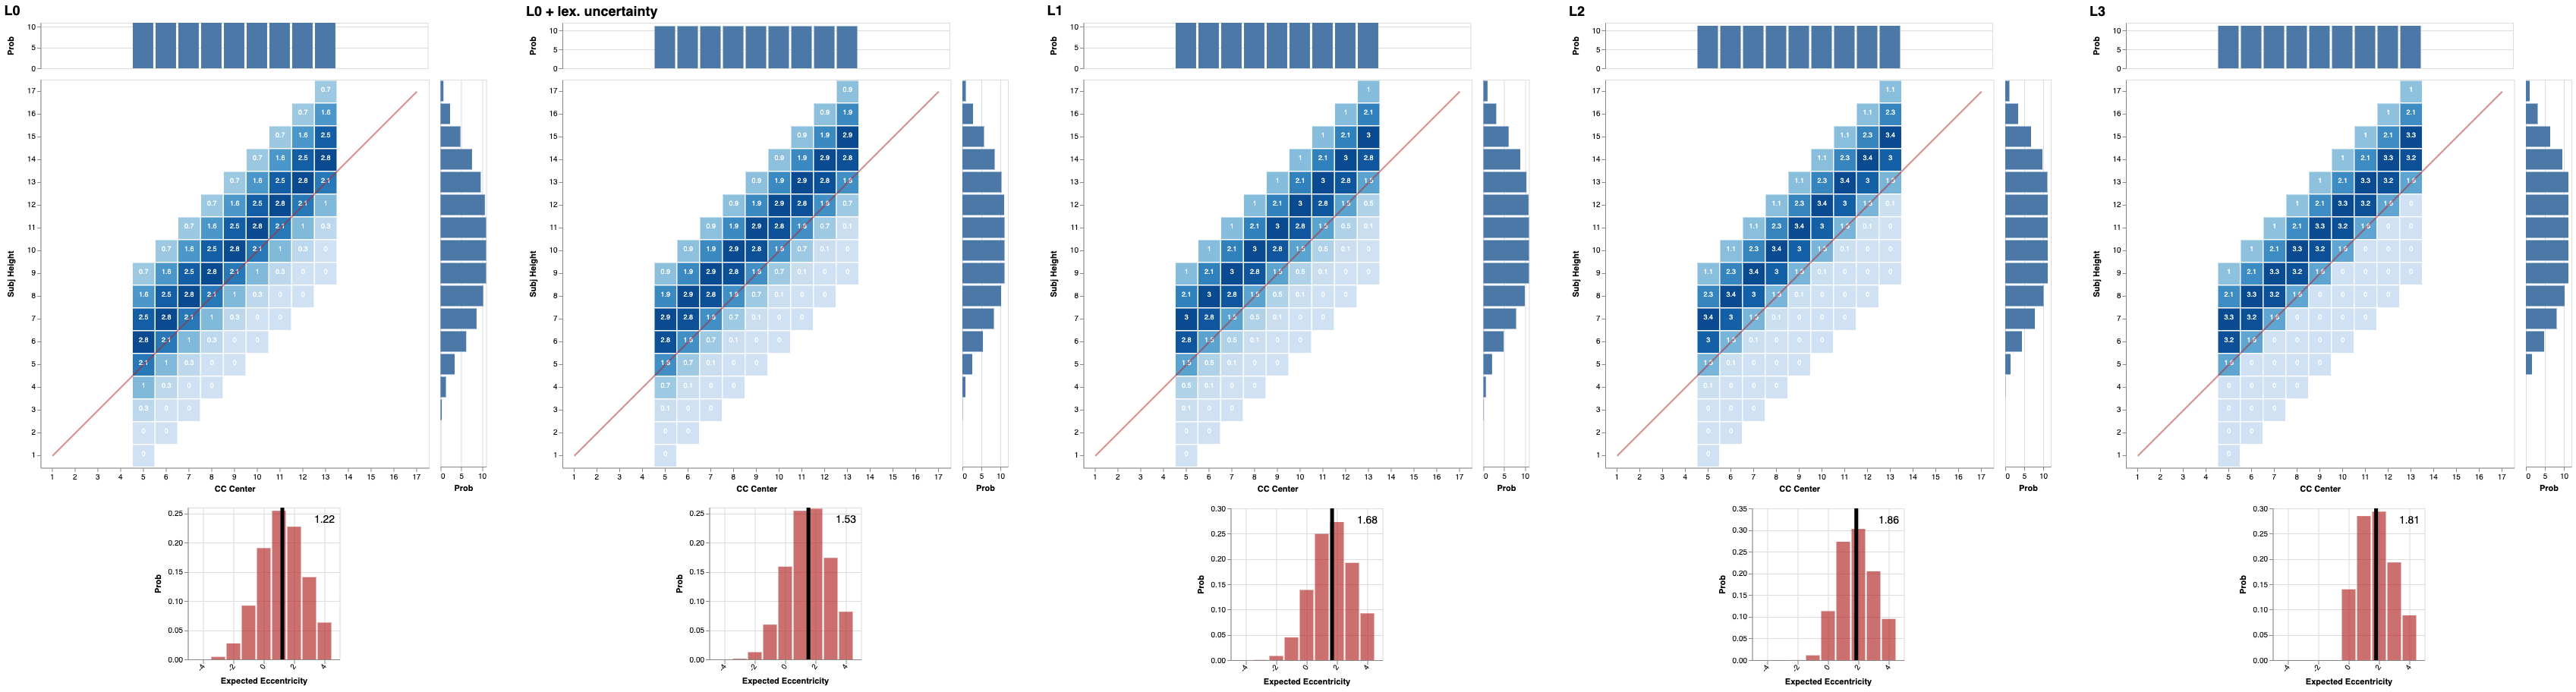

In [62]:
writeIORef cacheRef (0, Map.empty)
    
-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMCmp cacheRef (0, UTall, denCmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMCmp >>= \l -> listener infoLUMCmp cacheRef (0, UTall, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMCmp cacheRef (1, UTall, denCmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMCmp cacheRef (2, UTall, denCmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMCmp cacheRef (3, UTall, denCmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
--   [ ("L0", unif htsbill >>= \n -> listener infoLUMCmp cacheRef (0, UTall, denCmp0 n))
  [ ("L0", listener infoLUMCmp cacheRef (0, UTall, denCmp0 midpoint))
  , ("L0 + lex. uncertainty", lp infoLUMCmp >>= \l -> listener infoLUMCmp cacheRef (0, UTall, l))
  , ("L1", listener infoLUMCmp cacheRef (1, UTall, denCmp0 midpoint))
  , ("L2", listener infoLUMCmp cacheRef (2, UTall, denCmp0 midpoint))
  , ("L3", listener infoLUMCmp cacheRef (3, UTall, denCmp0 midpoint))
  ]

#### Pragmatic listener hears:

> "Joan is shorter than Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that Joan is almost certainly below the median

And as expected, the evaluativity effect is much stronger

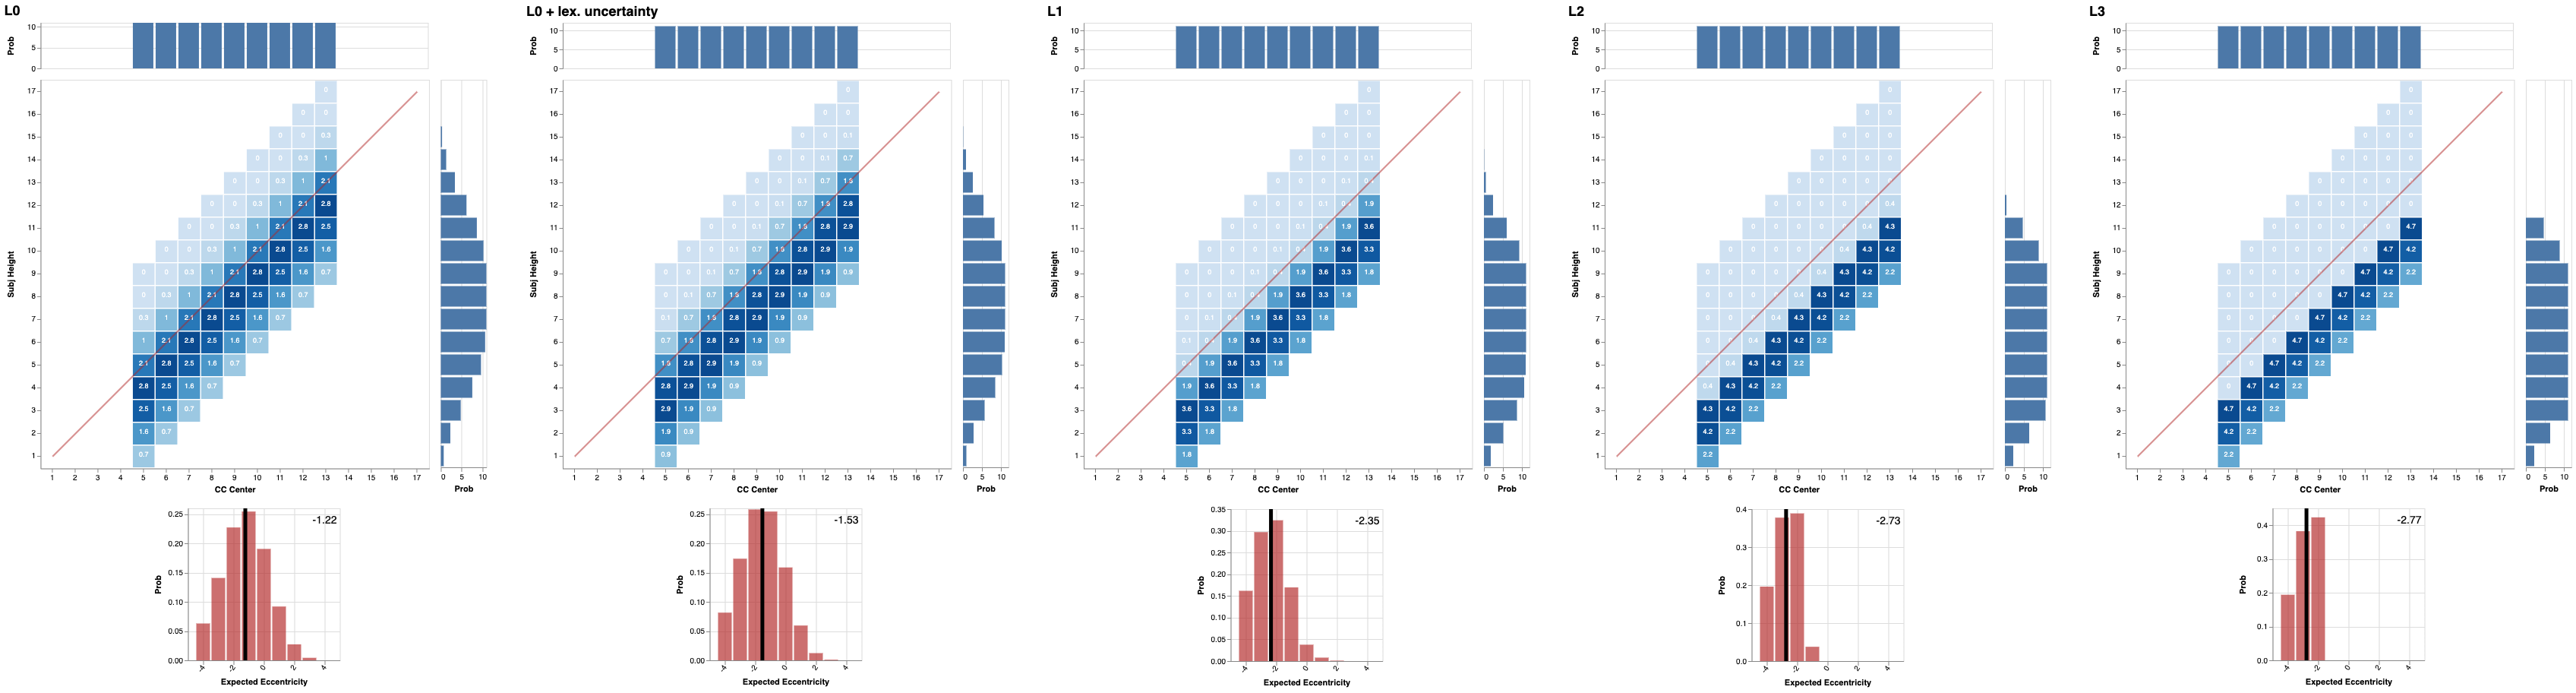

In [63]:
writeIORef cacheRef (0, Map.empty)

-- vlShow <$> mkEqGraph ("L0 literal listener", unif htsbill >>= \n -> listener infoLUMCmp cacheRef (0, UShrt, denCmp0 n))
-- vlShow <$> mkEqGraph ("L0 + lex. uncertainty", lp infoLUMCmp >>= \l -> listener infoLUMCmp cacheRef (0, UShrt, l))
-- vlShow <$> mkEqGraph ("L1 pragmatic listener", listener infoLUMCmp cacheRef (1, UShrt, denCmp0 midpoint))
-- vlShow <$> mkEqGraph ("L2 pragmatic listener", listener infoLUMCmp cacheRef (2, UShrt, denCmp0 midpoint))
-- vlShow <$> mkEqGraph ("L3 pragmatic listener", listener infoLUMCmp cacheRef (3, UShrt, denCmp0 midpoint))

vlShow . sidewaysDists <$> traverse mkEqGraph
--   [ ("L0", unif htsbill >>= \n -> listener infoLUMCmp cacheRef (0, UShrt, denCmp0 n))
  [ ("L0", listener infoLUMCmp cacheRef (0, UShrt, denCmp0 midpoint))
  , ("L0 + lex. uncertainty", lp infoLUMCmp >>= \l -> listener infoLUMCmp cacheRef (0, UShrt, l))
  , ("L1", listener infoLUMCmp cacheRef (1, UShrt, denCmp0 midpoint))
  , ("L2", listener infoLUMCmp cacheRef (2, UShrt, denCmp0 midpoint))
  , ("L3", listener infoLUMCmp cacheRef (3, UShrt, denCmp0 midpoint))
  ]

In [64]:
{-# LANGUAGE OverloadedStrings #-}

testBarFromDist :: (Ord a, Show a, Integral a) => [Int] -> Dist a -> VegaLite
testBarFromDist sds m =
  let vsps = toList m
      (vs,ps) = unzip vsps
      dvals = dataFromColumns []
              . dataColumn "sigma" (Numbers $ fmap fromIntegral vs)
              . dataColumn "prob" (Numbers $ fmap exp ps)
              . dataColumn "exp" (Numbers $ zipWith (\p v -> (/100) . fromIntegral . round . (100*) $ exp p * fromIntegral v) ps vs)

      enc = encoding
            . position X [ PName "sigma", PmType Quantitative, PAxis [AxLabelAngle (-55), AxTitle "Expected Eccentricity"], PSort []
                         -- , PScale [SDomain (DNumbers $ fmap fromIntegral sds)]
                         ]
            . position Y [PName "prob", PmType Quantitative, PAxis [AxTitle "Prob"]]
            
      barplot = [description "", dvals [], mark Bar [MColor "firebrick", MOpacity 0.65], enc []]
      barline = [description "", dvals [], mark Rule [], encoding . position X [PName "exp", PAggregate Sum] . size [MNumber 5] $ []]
      bartext = [description "", dvals [], mark Text [MFontSize 14], encoding . text [TName "exp", TAggregate Sum, TmType Quantitative] $ []]

  in toVegaLite [layer [asSpec barplot, asSpec barline, asSpec bartext]]
  
testSidewaysDists :: [VegaLite] -> VegaLite
testSidewaysDists ms =
  toVegaLite [ spacing 50
             , resolve (resolution (RScale [(ChColor, Independent)]) [])
             , hConcat (fromVL <$> ms)
             , configure . configuration (BarStyle [MContinuousBandSize 18]) $ []
             ]

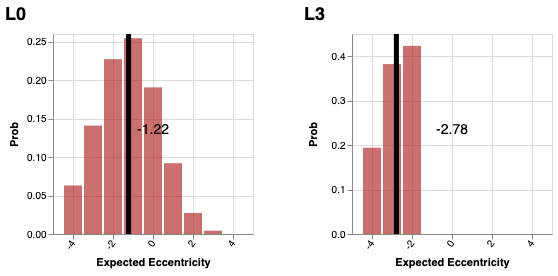

In [65]:
mkTestGraph (t, m) = do
  heat <- enumD (first ht    . fst <$> m)
--   bar  <- enumD (lexID    . snd <$> m)
  bar <- enumD (eccentricity . fst <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [ -- fromVL (margHeatFromDist heat)
                fromVL (testBarFromDist htrange bar)
              ]
    , title (pack t) [TFontSize 18]
    ]
    
vlShow . testSidewaysDists <$> traverse mkTestGraph
--   [ ("L0", unif htsbill >>= \n -> listener infoLUMCmp cacheRef (0, UShrt, denCmp0 n))
  [ ("L0", listener infoLUMCmp cacheRef (0, UShrt, denCmp0 midpoint))
--   , ("L0 + lex. uncertainty", lp infoLUMCmp >>= \l -> listener infoLUMCmp cacheRef (0, UShrt, l))
--   , ("L1", listener infoLUMCmp cacheRef (1, UShrt, denCmp0 midpoint))
--   , ("L2", listener infoLUMCmp cacheRef (2, UShrt, denCmp0 midpoint))
  , ("L3", listener infoLUMCmp cacheRef (3, UShrt, denCmp0 midpoint))
  ]